# Notebook for the audio feature of the dualsenseo controller.

## 1 Mic limitation

by using the externel device play the audio from 20hz to 22000hz, then plot the frequency of the mic detection

In [113]:
import numpy as np
import pyaudio
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram
from matplotlib.colors import LogNorm
import mplcursors

def list_microphones():
    pa = pyaudio.PyAudio()
    print("Available Microphone Devices:\n")
    
    for i in range(pa.get_device_count()):
        device_info = pa.get_device_info_by_index(i)
        if device_info['maxInputChannels'] > 0:
            print(f"Device Index: {i}")
            print(f"  Name: {device_info['name']}")
            print(f"  Channels: {device_info['maxInputChannels']}")
            print(f"  Default Sample Rate: {device_info['defaultSampleRate']}")
            print(f"  Is Default Input Device: {'Yes' if i == pa.get_default_input_device_info()['index'] else 'No'}")
            print("-" * 30)
    
    pa.terminate()

def get_device_channels(device_index):
    pa = pyaudio.PyAudio()
    device_info = pa.get_device_info_by_index(device_index)
    pa.terminate()
    return device_info['maxInputChannels']

def capture_and_visualize(device_index=0, duration=10, chunk=1024,show_ridge=False,show_h_l_label=False):
    # Get the actual number of channels for the device
    channels = 1

    # Parameters
    CHUNK = chunk
    FORMAT = pyaudio.paInt16
    RATE = 48000

    # Initialize PyAudio
    pa = pyaudio.PyAudio()

    try:
        # Open the selected audio input stream
        stream = pa.open(format=FORMAT,
                         channels=channels,
                         rate=RATE,
                         input=True,
                         input_device_index=device_index,
                         frames_per_buffer=CHUNK)

        print(f"Recording for {duration} seconds from device index {device_index} with {channels} channels...")

        # Collect audio data
        frames = []
        for _ in range(0, int(RATE / CHUNK * duration)):
            try:
                data = stream.read(CHUNK)
                frames.append(np.frombuffer(data, dtype=np.int16))
            except Exception as e:
                print(f"Error reading stream: {e}")
                break

        # Close the stream
        stream.stop_stream()
        stream.close()

        # Combine frames into a single numpy array
        audio_data = np.concatenate(frames)

        # Reshape based on number of channels
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            print(f"Audio input has {channels} channels. Analyzing channel 1 only.")
            channel_data = audio_data[:, 0]
        else:
            channel_data = audio_data

        # Time domain visualization
        plt.figure(figsize=(14, 10))
        plt.subplot(4, 1, 1)
        time_axis = np.linspace(0, len(channel_data) / RATE, num=len(channel_data))
        plt.plot(time_axis, channel_data, color='blue')
        plt.title("Sound Wave (Channel 1)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        # Frequency domain visualization (FFT)
        fft_data = fft(channel_data)
        fft_magnitude = np.abs(fft_data)[:len(fft_data) // 2]
        freqs = fftfreq(len(channel_data), 1 / RATE)[:len(fft_data) // 2]

        plt.subplot(4, 1, 2)
        plt.plot(freqs, fft_magnitude, color='red')
        plt.title("Frequency Spectrum (FFT - Channel 1)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")

        # Example FFT data
        threshold = 0.08 * max(fft_magnitude)  # Define a threshold as 10% of the max magnitude

        # Find frequencies within the threshold
        significant_indices = np.where(fft_magnitude > threshold)[0]
        lowest_frequency = freqs[significant_indices[0]]
        highest_frequency = freqs[significant_indices[-1]]

        if show_h_l_label:

            # Draw vertical lines for significant frequencies
            plt.axvline(x=lowest_frequency, color='green', linestyle='--', label=f'Lowest Significant Freq: {lowest_frequency:.2f} Hz')
            plt.axvline(x=highest_frequency, color='blue', linestyle='--', label=f'Highest Significant Freq: {highest_frequency:.2f} Hz')
            plt.legend(loc='lower right')
            plt.legend()

        # Spectrogram visualization using scipy.signal.spectrogram
        plt.subplot(4, 1, 3)
        f, t, Sxx = spectrogram(channel_data, fs=RATE, nperseg=2048, noverlap=1024, scaling='density')
        im = plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis', norm=LogNorm())
        plt.colorbar(label="Intensity (dB)")
        plt.title("Spectrogram (Channel 1)")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

        if show_h_l_label:
        # Draw horizontal lines for significant frequencies
            plt.axhline(y=lowest_frequency, color='green', linestyle='--', label=f'Lowest Significant Freq: {lowest_frequency:.2f} Hz')
            plt.axhline(y=highest_frequency, color='blue', linestyle='--', label=f'Highest Significant Freq: {highest_frequency:.2f} Hz')
            plt.legend(loc='lower right')
            plt.legend()

        # Find the time-frequency ridge with highest energy
        if show_ridge:
            ridge_freqs = f[np.argmax(Sxx, axis=0)]
            plt.plot(t, ridge_freqs, color='black', linestyle='--', linewidth=2, label='Highest Energy Ridge')
            plt.legend()



        
        

        # Add interactivity for hovering over the spectrogram
        cursor = mplcursors.cursor(im, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(
            f"Time: {t[sel.target[0]]:.2f}s\n"
            f"Highest Freq: {f[np.argmax(Sxx[:, sel.target[0]])]:.2f}Hz\n"
            f"Lowest Freq: {f[np.argmin(Sxx[:, sel.target[0]])]:.2f}Hz\n"
            f"Intensity: {10 * np.log10(Sxx[sel.target[1], sel.target[0]]):.2f}dB"))

        plt.tight_layout()
        plt.show()

        # Calculate average frequency and dominant frequency
        avg_frequency = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
        dominant_freq = freqs[np.argmax(fft_magnitude)]


        return avg_frequency, dominant_freq

    finally:
        pa.terminate()

In [79]:
list_microphones()

Available Microphone Devices:

Device Index: 1
  Name: DualSense Wireless Controller
  Channels: 2
  Default Sample Rate: 48000.0
  Is Default Input Device: No
------------------------------
Device Index: 2
  Name: MacBook Air Microphone
  Channels: 1
  Default Sample Rate: 48000.0
  Is Default Input Device: Yes
------------------------------
Device Index: 4
  Name: Wayne iPhone Microphone
  Channels: 1
  Default Sample Rate: 48000.0
  Is Default Input Device: No
------------------------------


#### 1.1 Macbook air default mic

Recording for 12 seconds from device index 2 with 1 channels...


/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_75849/695751609.py:147: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


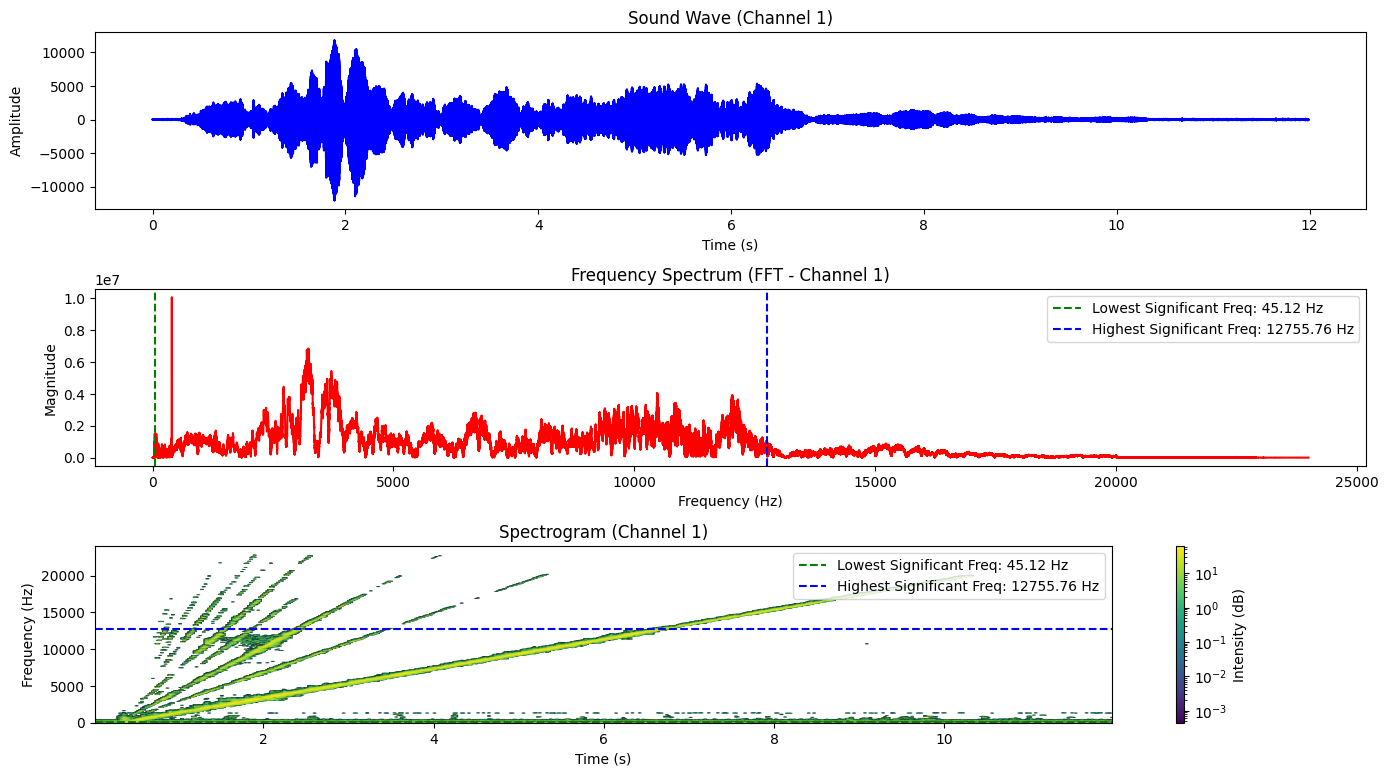

(np.float64(7306.134564429623), np.float64(399.77201957295375))

In [100]:
# play from the externel sound on the devcie of the macbook air m3 device 
capture_and_visualize(device_index=2, duration=12)


#### 1.2 Controller mic

Recording for 12 seconds from device index 1 with 1 channels...


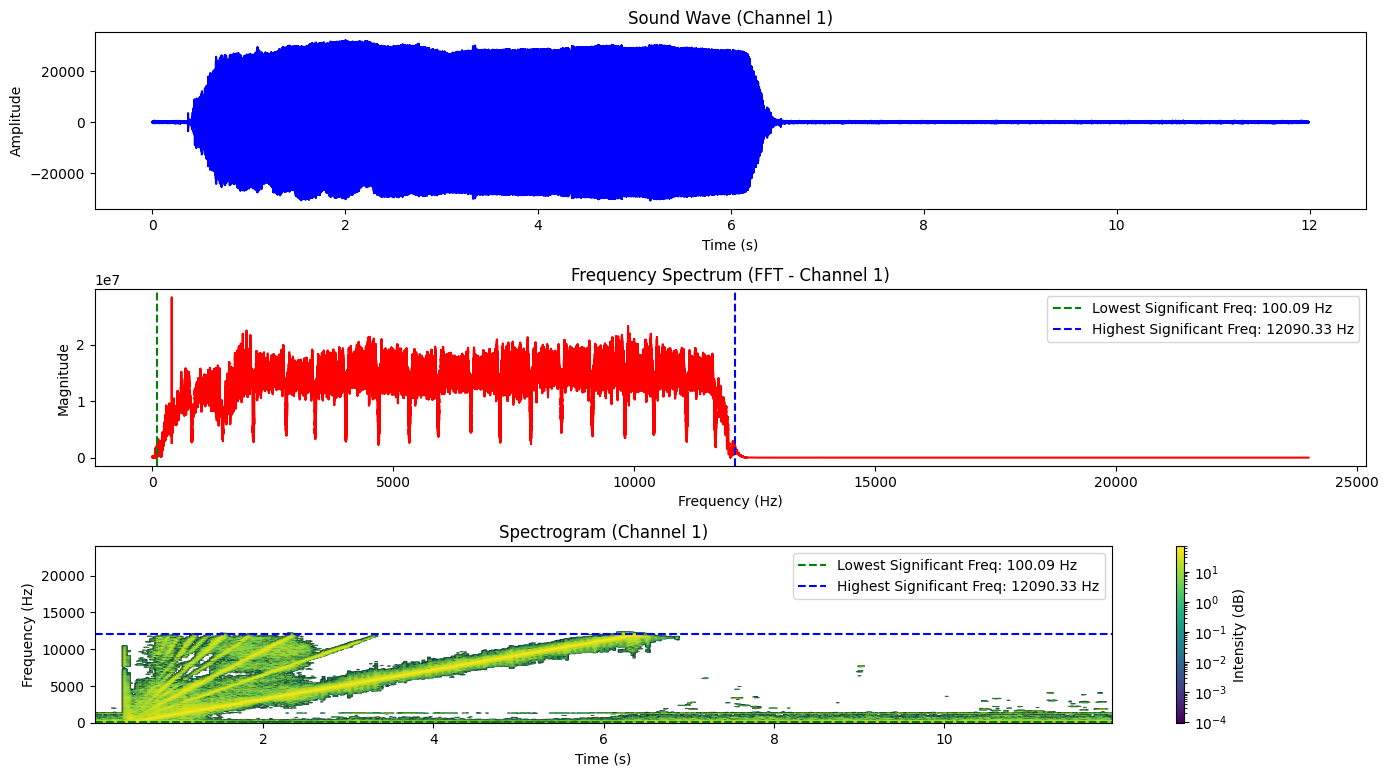

(np.float64(6304.798841295021), np.float64(400.2724644128114))

In [114]:
# play 11900hz max on the devcie of the controller
capture_and_visualize(device_index=1, duration=12,show_h_l_label=True)

Recording for 5 seconds from device index 1 with 1 channels...


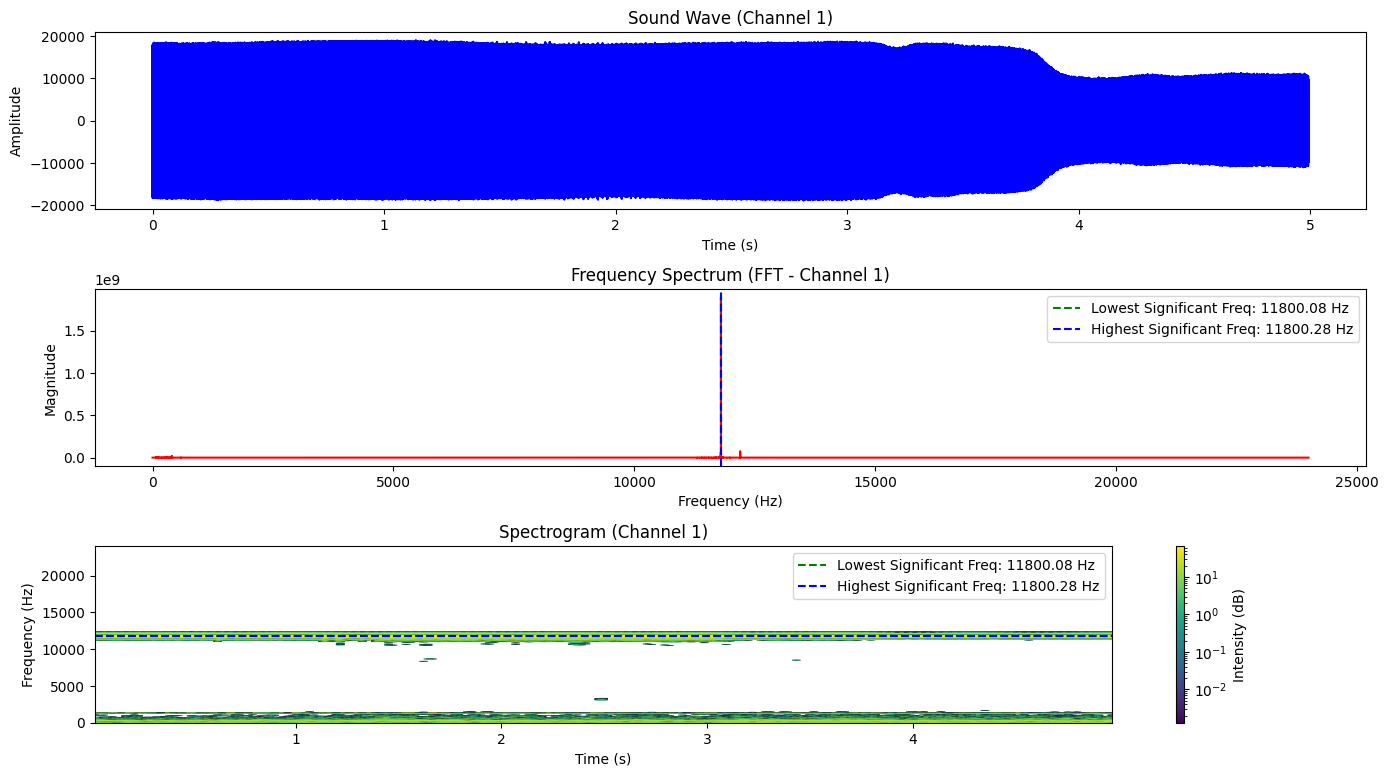

(np.float64(10082.954670574936), np.float64(11800.28044871795))

In [101]:
# high frequency bound, 11800
capture_and_visualize(device_index=1, duration=5)

Recording for 5 seconds from device index 1 with 1 channels...


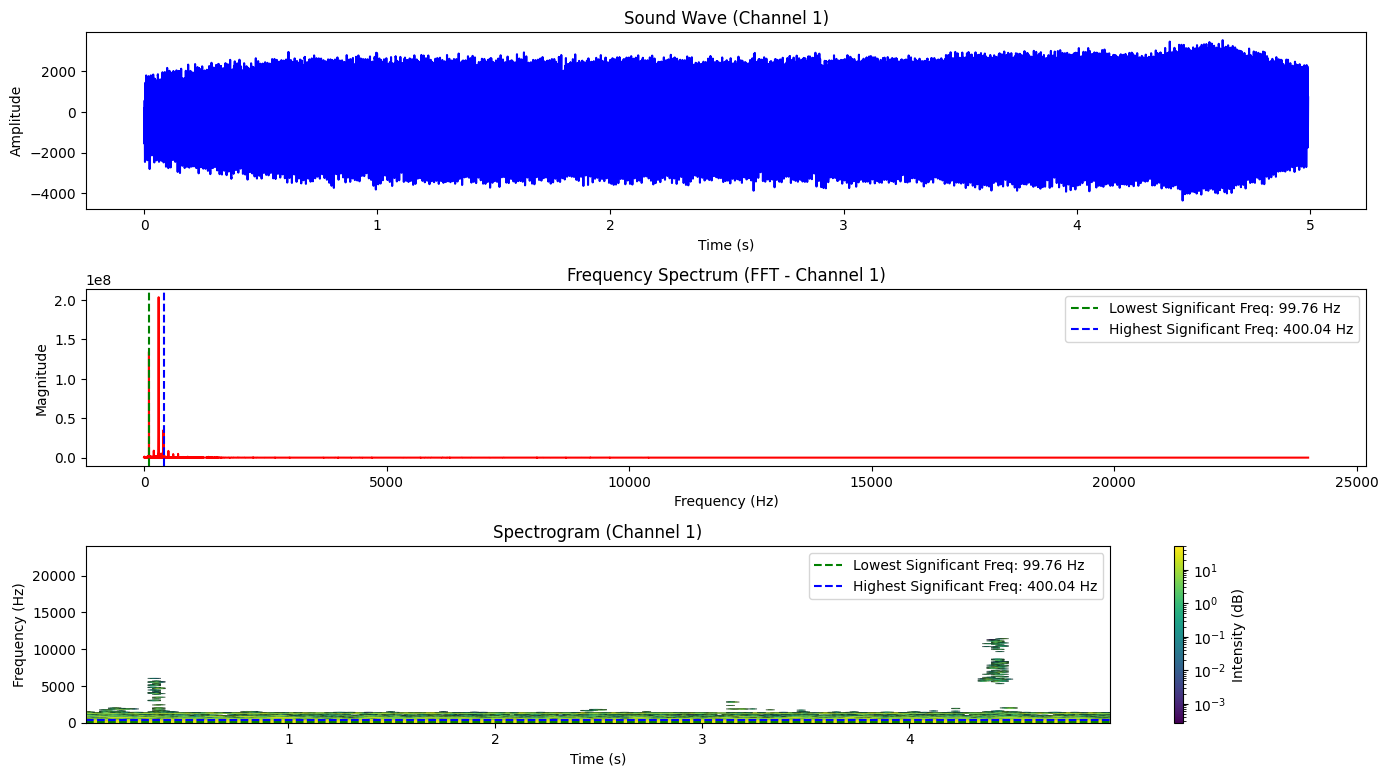

(np.float64(1769.9786511481054), np.float64(300.08012820512823))

In [108]:
# low frequency bound, 100 from externel sound
capture_and_visualize(device_index=1, duration=5)

### 1.3 Description about the spectrogram image .
- Radiating multiple lines in the spectrogram : Reflection and Echoes

- Limitatin of the controller frequency range  :100 hz to 11800hz 



## 2 Speaker Limitation

##### 2.1 List the speakers

In [29]:
import pyaudio

def list_speakers():
    """
    Lists all available audio output devices with their details.
    Returns a dictionary of output devices with their properties.
    """
    pa = pyaudio.PyAudio()
    output_devices = {}
    
    try:
        default_output = pa.get_default_output_device_info()
        print("\nDefault Output Device:")
        print(f"  Index: {default_output['index']}")
        print(f"  Name: {default_output['name']}")
        print(f"  Channels: {default_output['maxOutputChannels']}")
        print(f"  Sample Rate: {int(default_output['defaultSampleRate'])} Hz")
        print("\nAll Available Output Devices:")
        print("-" * 50)
        
        # Iterate through all audio devices
        for i in range(pa.get_device_count()):
            device_info = pa.get_device_info_by_index(i)
            
            # Check if device has output channels
            if device_info['maxOutputChannels'] > 0:
                output_devices[i] = {
                    'name': device_info['name'],
                    'channels': device_info['maxOutputChannels'],
                    'sample_rate': int(device_info['defaultSampleRate']),
                    'is_default': (i == default_output['index'])
                }
                
                print(f"\nDevice Index: {i}")
                print(f"  Name: {device_info['name']}")
                print(f"  Channels: {device_info['maxOutputChannels']}")
                print(f"  Default Sample Rate: {int(device_info['defaultSampleRate'])} Hz")
                print(f"  Is Default Device: {'Yes' if i == default_output['index'] else 'No'}")
                
                # Show supported sample rates if available
                try:
                    supported_rates = [
                        44100, 48000, 88200, 96000, 192000
                    ]
                    valid_rates = []
                    for rate in supported_rates:
                        try:
                            if pa.is_format_supported(
                                rate,
                                output_device=i,
                                output_channels=device_info['maxOutputChannels'],
                                output_format=pyaudio.paFloat32
                            ):
                                valid_rates.append(rate)
                        except ValueError:
                            continue
                    
                    if valid_rates:
                        print(f"  Supported Sample Rates: {', '.join(map(str, valid_rates))} Hz")
                except Exception as e:
                    print(f"  Could not determine supported sample rates: {e}")
                
                print("-" * 50)
        
        return output_devices
    
    finally:
        pa.terminate()

def get_speaker_info(device_index):
    """
    Get detailed information about a specific output device.
    
    Args:
        device_index (int): The index of the output device
    
    Returns:
        dict: Device information or None if device not found
    """
    pa = pyaudio.PyAudio()
    try:
        device_info = pa.get_device_info_by_index(device_index)
        if device_info['maxOutputChannels'] > 0:
            return {
                'name': device_info['name'],
                'channels': device_info['maxOutputChannels'],
                'sample_rate': int(device_info['defaultSampleRate']),
                'is_default': (device_index == pa.get_default_output_device_info()['index'])
            }
        return None
    except Exception as e:
        print(f"Error getting device info: {e}")
        return None
    finally:
        pa.terminate()



# List all available output devices
speakers = list_speakers()

# Get info about a specific speaker
device_index = 0  # Replace with the index of the speaker you're interested in
speaker_info = get_speaker_info(device_index)
if speaker_info:
    print(f"\nSelected Speaker Details:")
    print(f"Name: {speaker_info['name']}")
    print(f"Channels: {speaker_info['channels']}")
    print(f"Sample Rate: {speaker_info['sample_rate']} Hz")
    print(f"Is Default: {speaker_info['is_default']}")


Default Output Device:
  Index: 0
  Name: DualSense Wireless Controller
  Channels: 4
  Sample Rate: 48000 Hz

All Available Output Devices:
--------------------------------------------------

Device Index: 0
  Name: DualSense Wireless Controller
  Channels: 4
  Default Sample Rate: 48000 Hz
  Is Default Device: Yes
--------------------------------------------------

Device Index: 3
  Name: MacBook Air Speakers
  Channels: 2
  Default Sample Rate: 48000 Hz
  Is Default Device: No
||PaMacCore (AUHAL)|| Warning on line 521: err=''!obj'', msg=Unknown Error
||PaMacCore (AUHAL)|| Warning on line 441: err=''!obj'', msg=Unknown Error
||PaMacCore (AUHAL)|| Error on line 1332: err='-10851', msg=Audio Unit: Invalid Property Value
||PaMacCore (AUHAL)|| OpenStream @ 44100 returned: -9986: Internal PortAudio error
||PaMacCore (AUHAL)|| Warning on line 521: err=''!obj'', msg=Unknown Error
||PaMacCore (AUHAL)|| Warning on line 441: err=''!obj'', msg=Unknown Error
||PaMacCore (AUHAL)|| Error on line 

### 2.2 Helper function about the sound
- playtone ( frequency)
- Play sweeping sound 
- play sweeping sound to certain channels
- Analysis audio file

In [24]:
import numpy as np
import pyaudio
import time
import librosa  
import matplotlib.pyplot as plt
import librosa.display
import soundfile as sf
import os

def speaker_info(device_index):
    """
    Get detailed information about a specific output device.
    
    Args:
        device_index (int): The index of the output device
    
    Returns:
        dict: Device information or None if device not found
    """
    pa = pyaudio.PyAudio()
    try:
        device_info = pa.get_device_info_by_index(device_index)
        return device_info
    except Exception as e:
        print(f"Error getting device info: {e}")
        return None


def play_tone(frequency, duration, device_index=None, volume=1.0, sample_rate=48000, amplitude=1.0):
    """
    Play a sine wave tone with specified frequency and duration on selected device.
    
    Args:
        frequency (float): Frequency of the tone in Hz
        duration (float): Duration of the tone in seconds
        device_index (int): Index of the output device (None for default device)
        volume (float): Volume of the tone (0.0 to 2.0, values > 1.0 will amplify)
        sample_rate (int): Sample rate in Hz
        amplitude (float): Additional amplitude scaling (1.0 to 5.0, use carefully)
    """
    # Initialize PyAudio
    pa = pyaudio.PyAudio()
    
    try:
        # Generate samples for the sine wave
        samples = np.arange(int(duration * sample_rate))
        sine_wave = np.sin(2.0 * np.pi * frequency * samples / sample_rate)
        
        # Apply volume and amplitude scaling
        amplified_wave = sine_wave * volume * amplitude
        
        # Clip the wave to prevent distortion
        amplified_wave = np.clip(amplified_wave, -1.0, 1.0)
        
        # Convert to 32-bit float
        audio_data = amplified_wave.astype(np.float32)
        
        # Open stream with higher buffer size for better performance
        stream = pa.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=sample_rate,
            output=True,
            output_device_index=device_index,
            frames_per_buffer=2048  # Increased buffer size
        )
        
        try:
            # Play the tone
            print(f"Playing {frequency}Hz tone for {duration} seconds on device index {device_index}")
            print(f"Volume level: {volume}, Amplitude scaling: {amplitude}")
            stream.write(audio_data.tobytes())
            
            # Wait until playback is finished
            time.sleep(duration/10)
            
        finally:
            stream.stop_stream()
            stream.close()
            
    finally:
        pa.terminate()

def play_sweep(start_freq, end_freq, duration, device_index=None, volume=0.5, sample_rate=48000,channels=2):
    """
    Play a frequency sweep from start_freq to end_freq and back to start_freq.
    
    Args:
        start_freq (float): Starting frequency in Hz
        end_freq (float): Ending frequency in Hz
        duration (float): Duration of the sweep in seconds
        device_index (int): Index of the output device (None for default device)
        volume (float): Volume of the sweep (0.0 to 1.0)
        sample_rate (int): Sample rate in Hz
    """
    print(speaker_info(device_index))
    pa = pyaudio.PyAudio()
    
    try:
        # Generate time array
        t = np.linspace(0, duration, int(sample_rate * duration))
        
        # Generate logarithmic frequency sweep up and down
        half_duration = duration / 2
        t_half = np.linspace(0, half_duration, int(sample_rate * half_duration))
        
        freq_up = np.exp(np.log(start_freq) + (np.log(end_freq/start_freq) * t_half/half_duration))
        freq_down = np.exp(np.log(end_freq) + (np.log(start_freq/end_freq) * t_half/half_duration))
        
        freq = np.concatenate((freq_up, freq_down))
        phase = 2 * np.pi * freq.cumsum() / sample_rate
        sweep = np.sin(phase)
        
        # Apply volume and convert to 32-bit float
        audio_data = (sweep * volume).astype(np.float32)
        
        # Open stream
        stream = pa.open(
            format=pyaudio.paFloat32,
            channels=channels,
            rate=sample_rate,
            output=True,
            output_device_index=device_index,
            frames_per_buffer=1024
        )
        
        try:
            # Play the sweep
            print(f"Playing frequency sweep from {start_freq}Hz to {end_freq}Hz and back for {duration} seconds")
            stream.write(audio_data.tobytes())
            
            # Wait until playback is finished
            time.sleep(duration)
            
        finally:
            stream.stop_stream()
            stream.close()
            
    finally:
        pa.terminate()

def play_sweep_one_channel(start_freq, end_freq, duration, device_index=None, channel_index=0, total_channels=4, volume=0.5, sample_rate=48000):
    """
    Play a frequency sweep on a specific channel of a multi-channel device.
    
    Args:
        start_freq (float): Starting frequency in Hz
        end_freq (float): Ending frequency in Hz
        duration (float): Duration of the sweep in seconds
        device_index (int): Index of the output device (None for default device)
        channel_index (int): Index of the target channel (0-based)
        total_channels (int): Total number of channels on the device
        volume (float): Volume of the sweep (0.0 to 1.0)
        sample_rate (int): Sample rate in Hz
    """


    print(speaker_info(device_index))

    pa = pyaudio.PyAudio()
    
    try:
        # Generate time array
        t = np.linspace(0, duration, int(sample_rate * duration))
        
        # Generate logarithmic frequency sweep up and down
        half_duration = duration / 2
        t_half = np.linspace(0, half_duration, int(sample_rate * half_duration))
        
        freq_up = np.exp(np.log(start_freq) + (np.log(end_freq/start_freq) * t_half/half_duration))
        freq_down = np.exp(np.log(end_freq) + (np.log(start_freq/end_freq) * t_half/half_duration))
        
        freq = np.concatenate((freq_up, freq_down))
        phase = 2 * np.pi * freq.cumsum() / sample_rate
        sweep = np.sin(phase)
        
        # Apply volume and convert to 32-bit float
        sweep_audio = (sweep * volume).astype(np.float32)
        
        # Embed the audio in the specified channel
        # Create a silent audio buffer for all channels
        audio_data = np.zeros((len(sweep_audio), total_channels), dtype=np.float32)
        audio_data[:, channel_index] = sweep_audio  # Set the sweep audio to the desired channel
        
        # Interleave channels for PyAudio
        interleaved_audio = audio_data.flatten()
        
        # Open stream
        stream = pa.open(
            format=pyaudio.paFloat32,
            channels=total_channels,
            rate=sample_rate,
            output=True,
            output_device_index=device_index,
            frames_per_buffer=1024
        )
        
        try:
            # Play the sweep
            print(f"Playing frequency sweep from {start_freq}Hz to {end_freq}Hz and back for {duration} seconds on channel {channel_index}")
            stream.write(interleaved_audio.tobytes())
            
            # Wait until playback is finished
            time.sleep(duration)
            
        finally:
            stream.stop_stream()
            stream.close()
            
    finally:
        pa.terminate()


# this function is for the sweeping audio file to get the frequency boundary     
def freq_bounrady_sweeping(audio_file_path,threshold=0.4):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)
    S=librosa.stft(y,n_fft=2048,hop_length=512)

    # compute the average power spectrogram
    power_spectrogram = np.mean(np.abs(S),axis=1)
    frequencies=librosa.fft_frequencies(sr=sr,n_fft=2048)
    
    # threshold
    threshold = threshold * np.mean(power_spectrogram)  # Define a threshold as 10% of the max magnitude
    detected_freq=frequencies[power_spectrogram>threshold]
    print(detected_freq)

    min_freq=detected_freq[0] if len(detected_freq)>0 else 0
    max_freq=detected_freq[-1] if len(detected_freq)>0 else 0
    
    print(f"Lowest Significant Frequency: {min_freq:.2f} Hz, Highest Significant Frequency: {max_freq:.2f} Hz")
    return min_freq,max_freq


# Plot the audio waveform, FFT, and spectrogram of an audio file
def analysis_audio(audio_file_path):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)
    
    # Plot the audio waveform
    plt.figure(figsize=(14, 12))
    plt.subplot(4, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Audio Waveform - {os.path.basename(audio_file_path)}')
    
    # Plot the FFT (frequency domain)
    plt.subplot(4, 1, 2)
    D = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    plt.plot(freqs, np.mean(D, axis=1))
    plt.title(f'FFT - {os.path.basename(audio_file_path)}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    
    # Plot the spectrogram
    plt.subplot(4, 1, 3)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram - {os.path.basename(audio_file_path)}')
    
    # Plot the normal spectrogram
    plt.subplot(4, 1, 4)
    S = np.abs(librosa.stft(y))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {os.path.basename(audio_file_path)}')
    
    plt.tight_layout()
    plt.show()

- NOTE:
Due to the driver issue on the macos , the controller should bluetooth connected the mac then wire connect the mac , then it will works as speaker

### 2.3 Play sound 

In [26]:
play_tone(2000,10,0)

Playing 2000Hz tone for 10 seconds on device index 0
Volume level: 1.0, Amplitude scaling: 1.0


In [16]:
# play sound through the mac
play_sweep(20,500,20,device_index=3,volume=1)

{'index': 3, 'structVersion': 2, 'name': 'MacBook Air Speakers', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.024125, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.044125, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 20Hz to 500Hz and back for 20 seconds


In [23]:
# play sound through the controller
play_sweep(10,80,20,device_index=0,volume=1)

{'index': 0, 'structVersion': 2, 'name': 'DualSense Wireless Controller', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 4, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.0451875, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 10Hz to 80Hz and back for 20 seconds


In [ ]:
play_sweep(20,30000,60,device_index=0,volume=1)

/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_75849/1798818487.py:237: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path, sr=None)
/opt/miniconda3/envs/dualsense/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


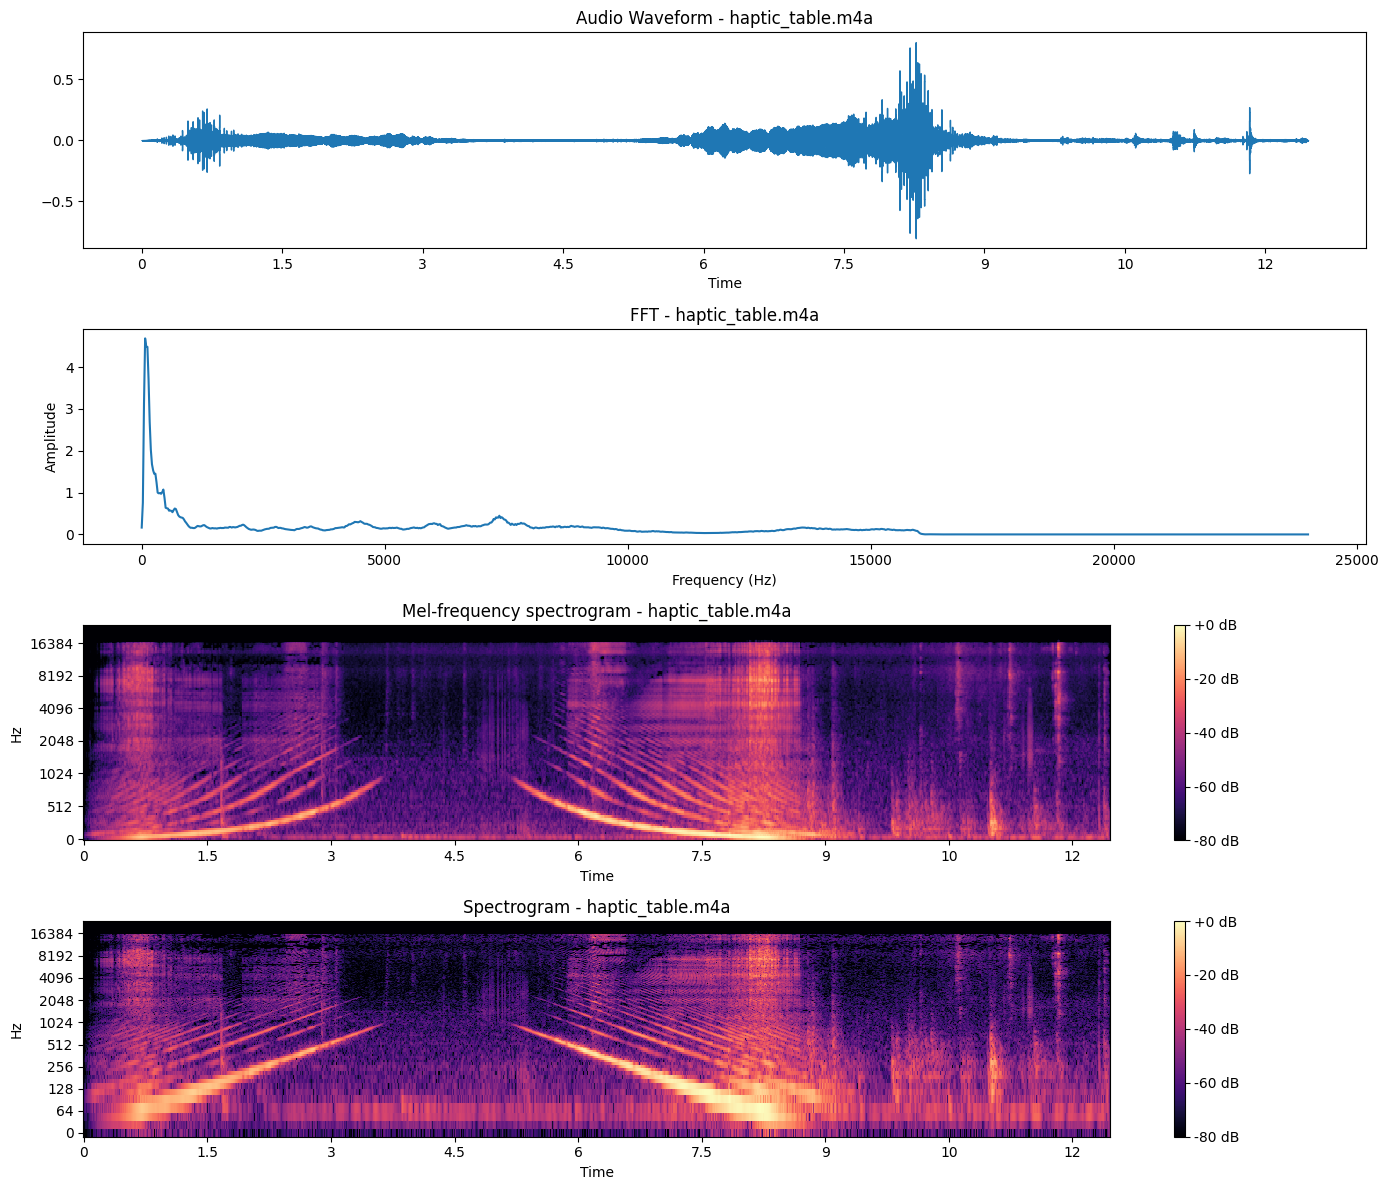

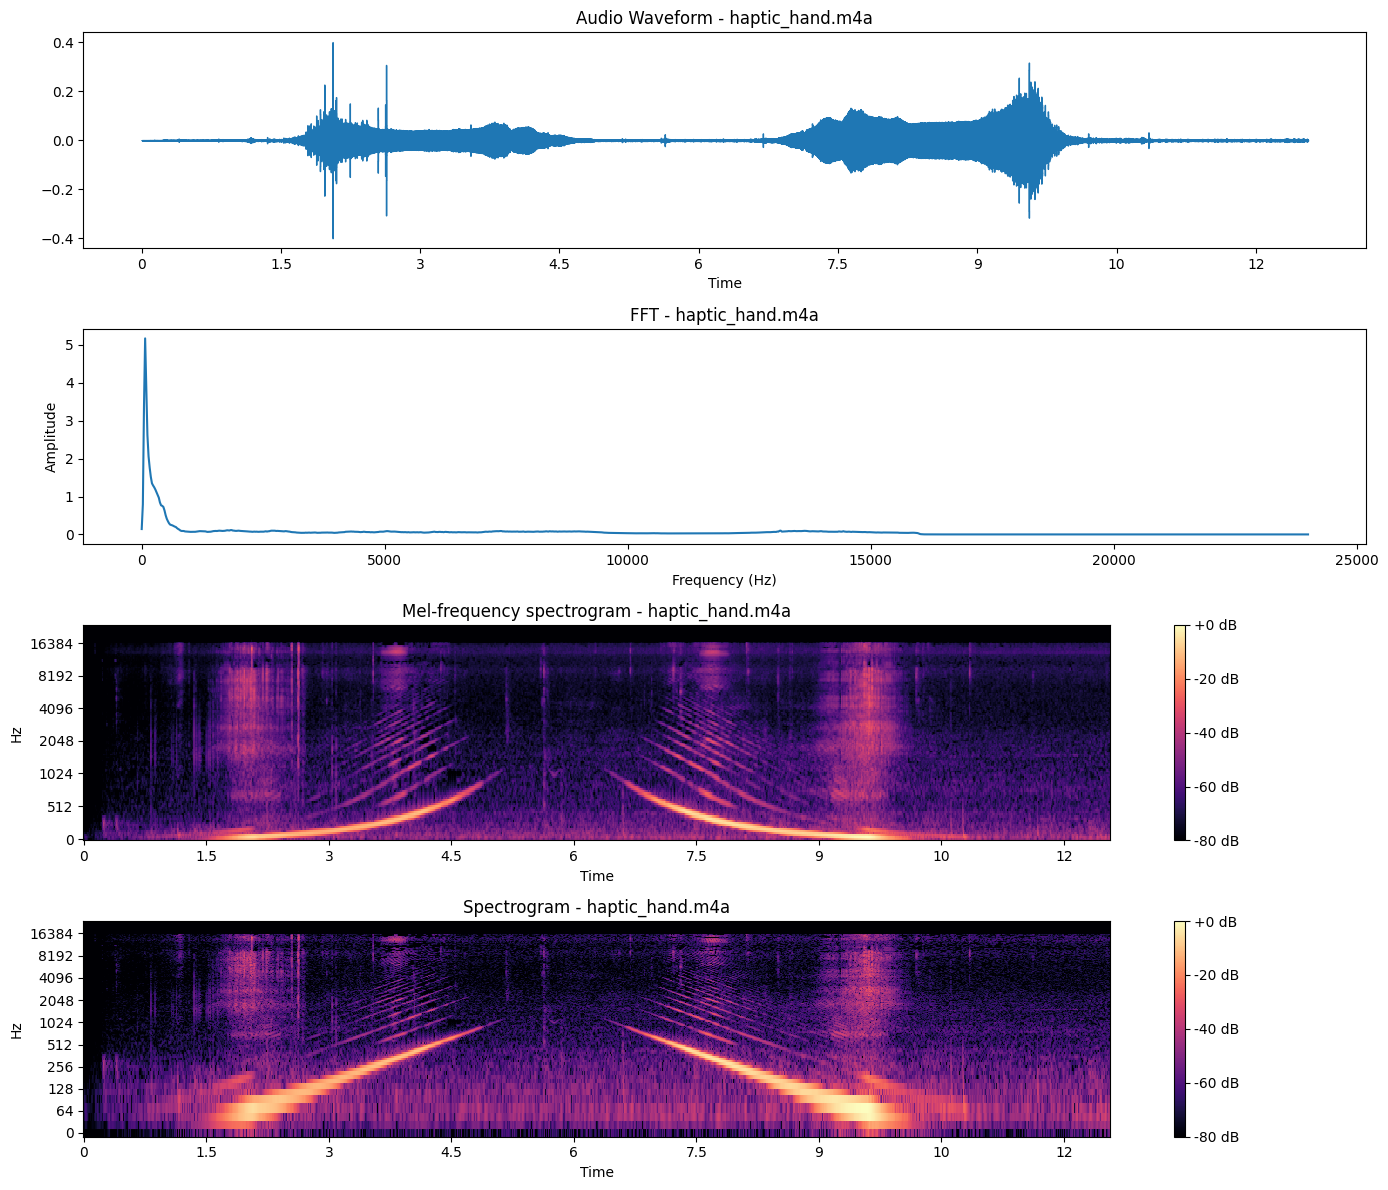

In [ ]:
# analysis the haptic audio m4a file , record by iphone 12 , sound play from controller

analysis_audio("haptic_table.m4a")
analysis_audio("haptic_hand.m4a")


In [275]:
# play the sweeping in low frequency bound from 20hz to 500 hz 
play_sweep(500,1200,20,device_index=0,volume=1)

{'index': 0, 'structVersion': 2, 'name': 'DualSense Wireless Controller', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 4, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.023854166666666666, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 500Hz to 1200Hz and back for 20 seconds


### 2.3 Transfer Function Analysis with Spectral Coherence 

Can not align the input and output signal 


The speaker and motor each have distinct frequency responses (how they convert input signals to output vibrations/sound). By comparing the input sweep signal to the recorded output, you can model the combined system’s transfer function. Frequency regions where the output amplitude deviates from the input (e.g., attenuation or resonance) may indicate the operational limits of each component.

- Generate Input Signal: Use a 20Hz–2000Hz linear/logarithmic sweep with a flat amplitude profile.

- Record Output: Capture the audio from the controller using your external device.

- Compute Transfer Function:

    - Perform FFT on the input and output signals.

    - Calculate the transfer function: 



**H(f)** =   FFT\(_{output}\)(f)  \ FFT\(_{input}\)(f) 


Analyze Results:

Roll-off points: Sudden drops in magnitude (e.g., >6 dB/octave) suggest a component’s frequency limit.

Resonances: Peaks in specific bands (e.g., 100–300Hz for motors) indicate mechanical/electrical resonances.

Overlap: Flat regions (e.g., 300–500Hz) imply both components contribute.

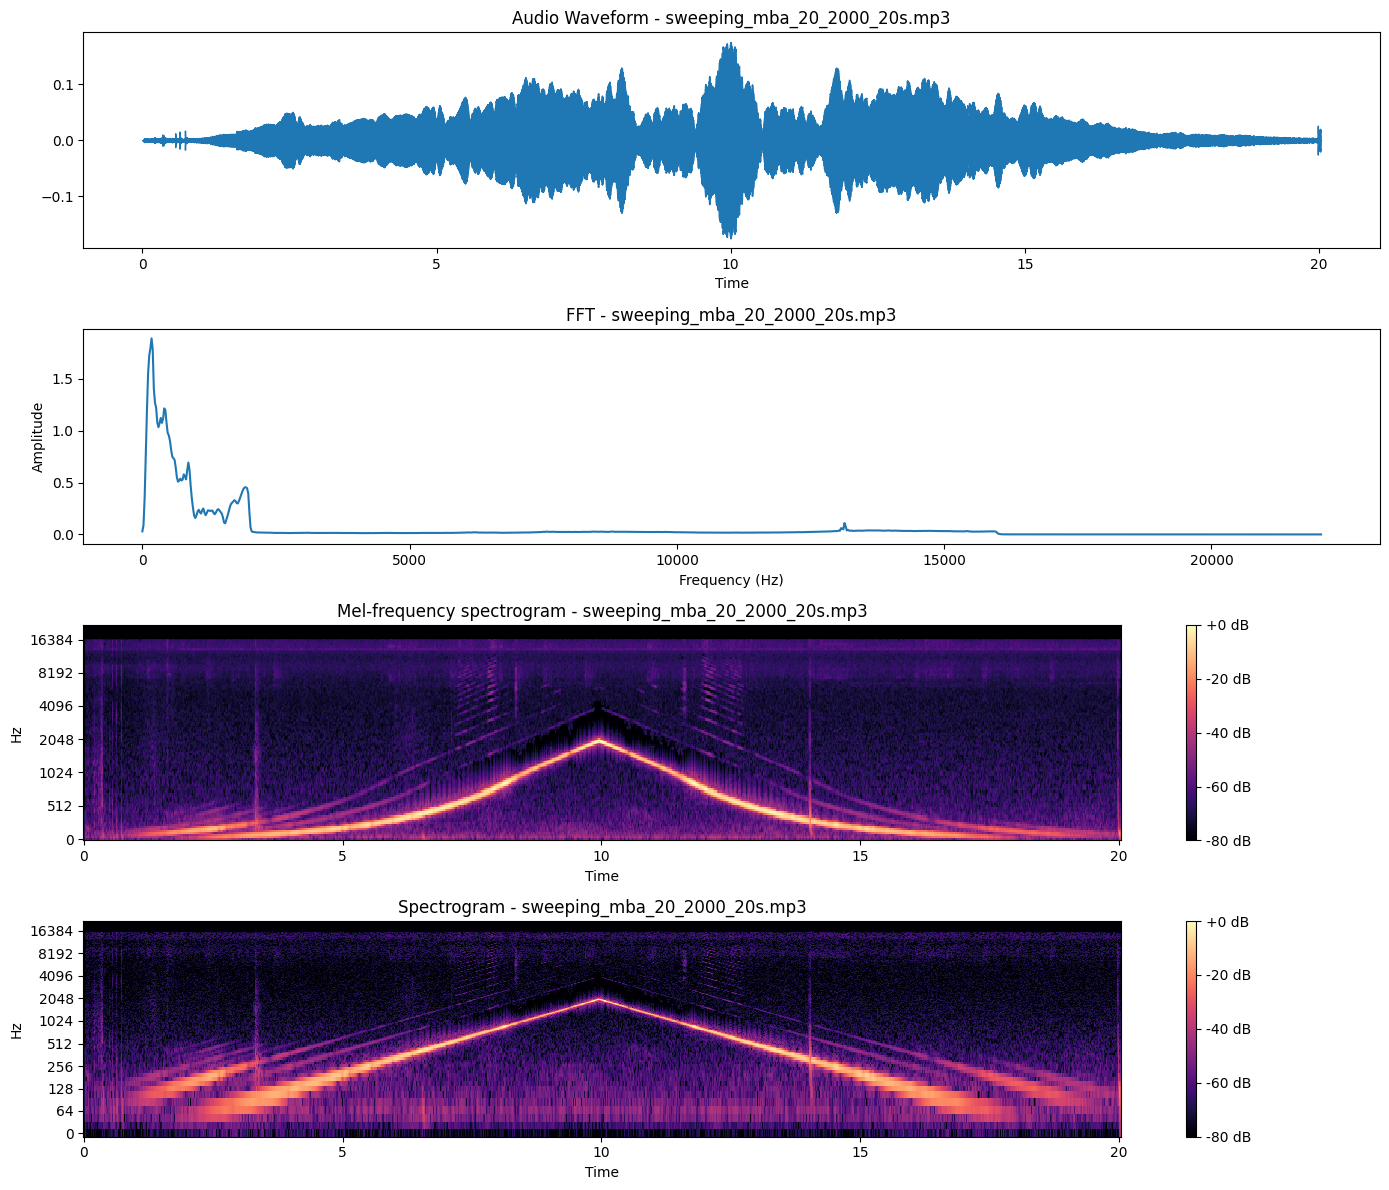

In [24]:
# shwo the 20s of the macbook air speaker's output of thw sweeping 20 2000 hz 
analysis_audio("./audio_file/sweeping_mba_20_2000_20s.mp3")

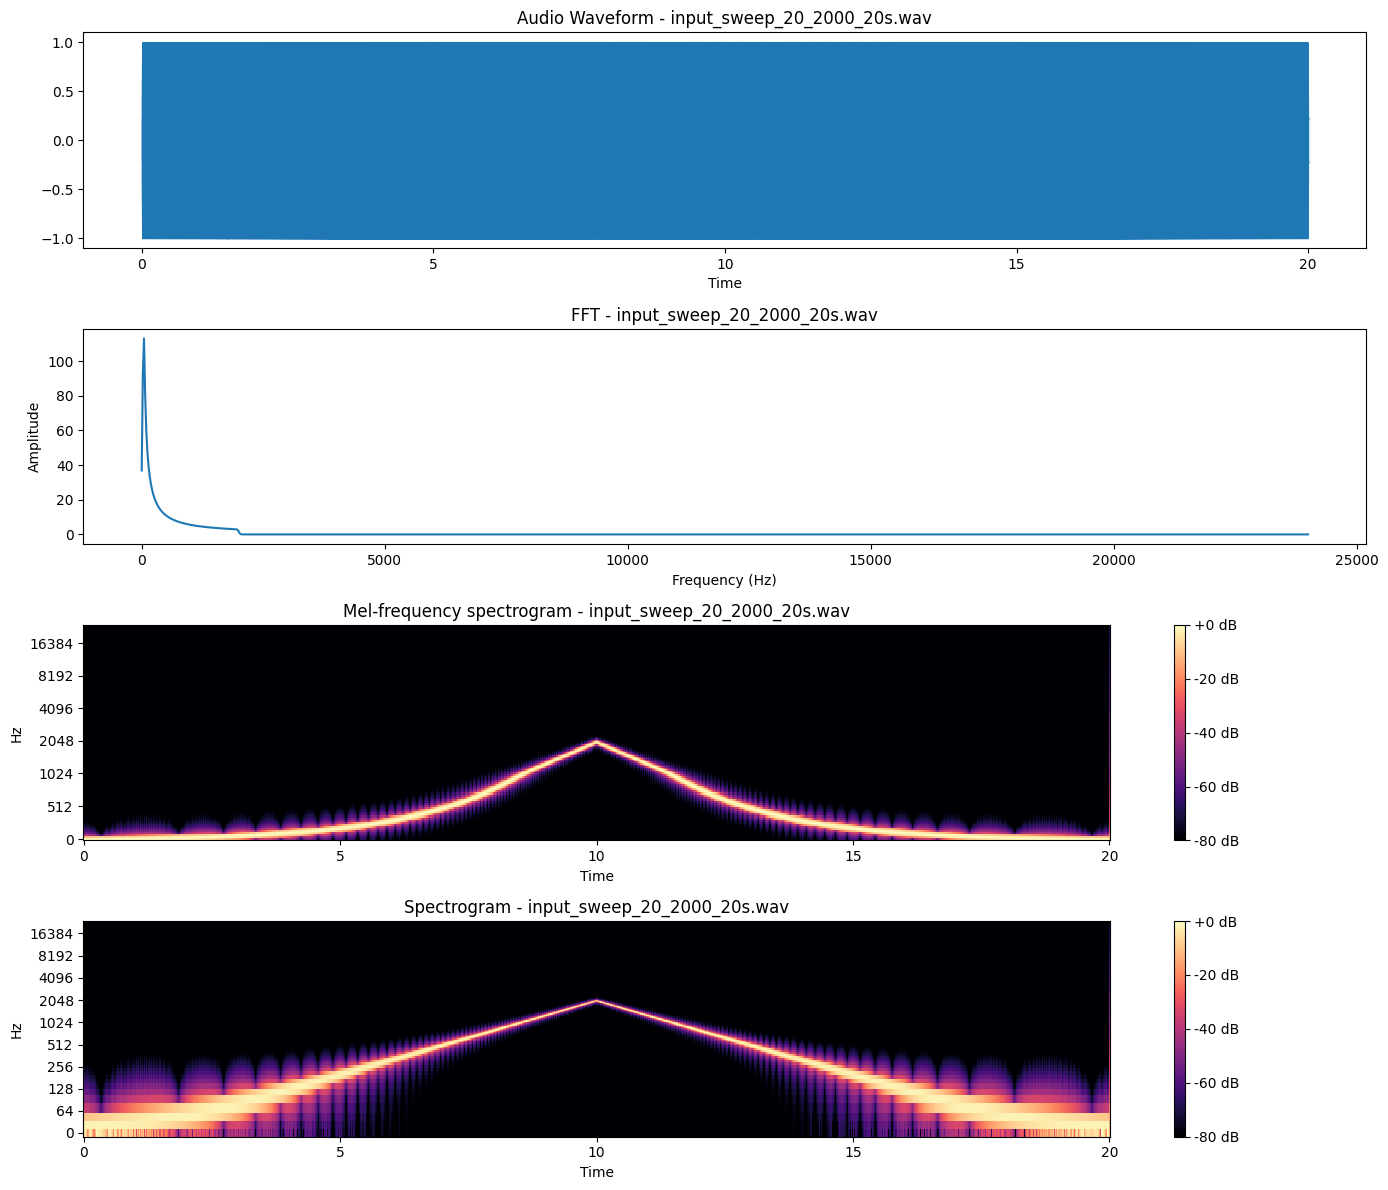

In [83]:
analysis_audio("./audio_file/input_sweep_20_2000_20s.wav")

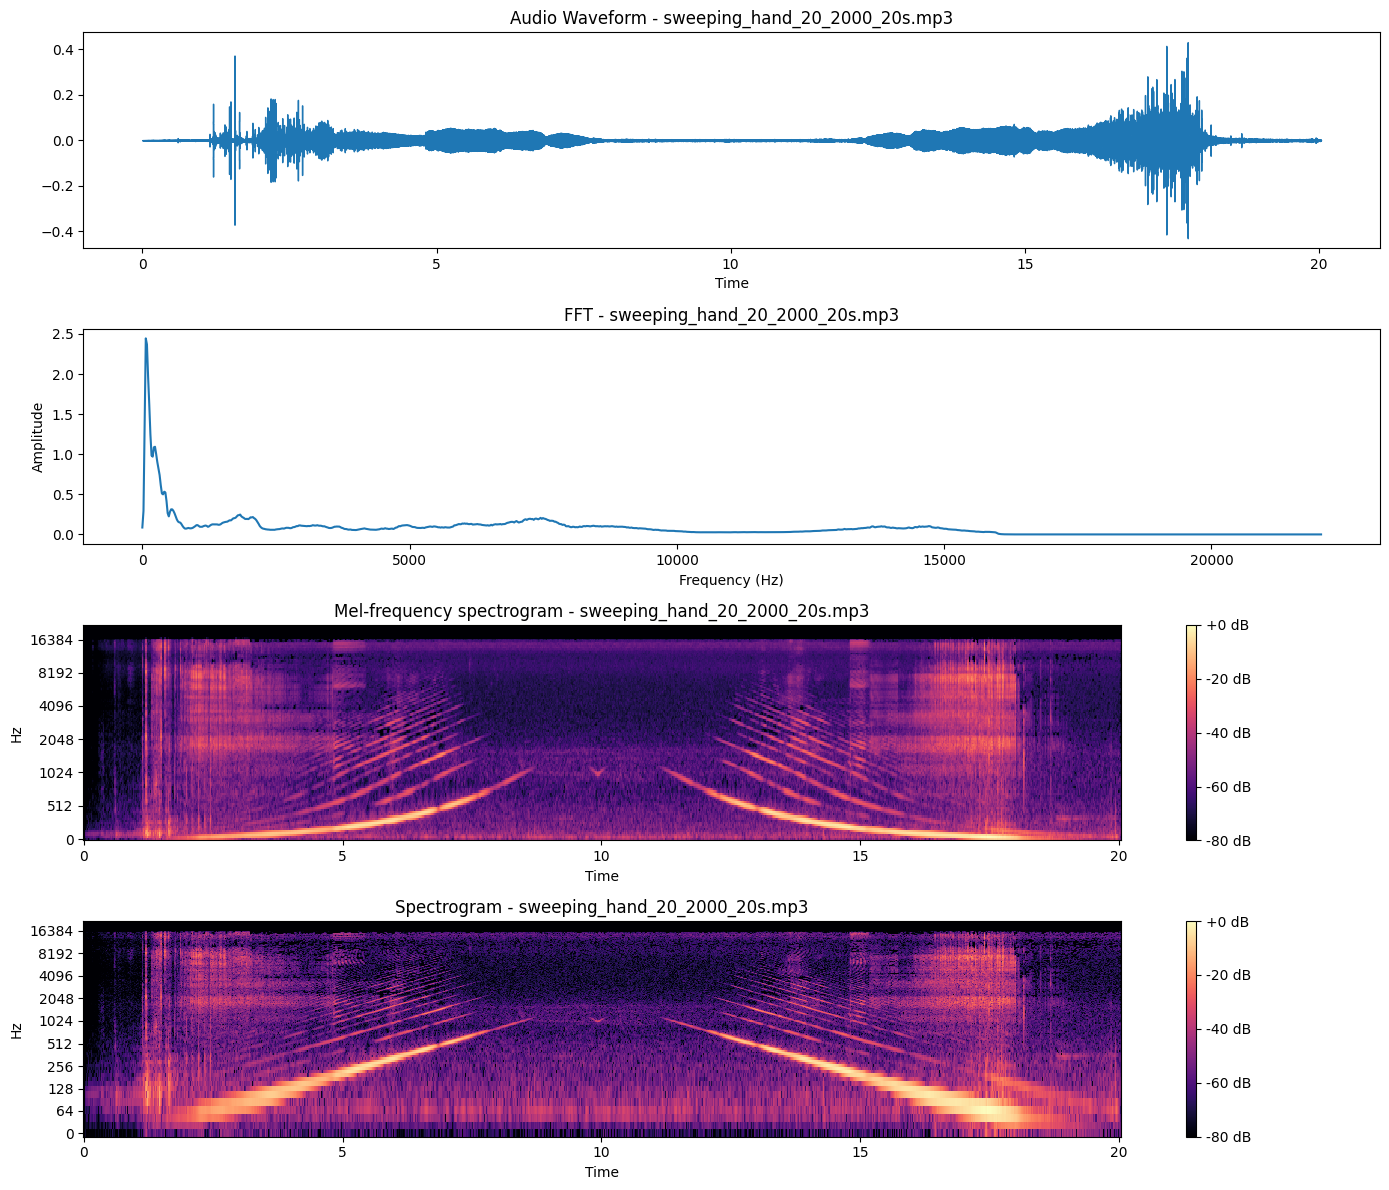

In [35]:
analysis_audio("./audio_file/sweeping_hand_20_2000_20s.mp3")

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import librosa
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

# this function is for the alignment and scaling of the input and output signal 
def align_and_scale_signals(input_sig, output_sig):
        # Add initial length check
    if len(output_sig) < len(input_sig):
        raise ValueError("Output signal shorter than input!")
    
    def objective(params):
        delay, scale = params
        start = int(np.round(delay))
        if start < 0 or start+len(input_sig) > len(output_sig):
            return np.inf
        aligned = scale * output_sig[start:start+len(input_sig)]
        return np.mean((input_sig - aligned)**2)
    
    # Initial guess
    correlation = signal.correlate(output_sig, input_sig, mode='valid')
    delay_guess = np.argmax(correlation)
    scale_guess = np.std(input_sig)/np.std(output_sig)
    
    res = minimize(objective, [delay_guess, scale_guess], 
                   bounds=((0, len(output_sig)-len(input_sig)), (0.1, 10)))
    delay_opt, scale_opt = res.x
    
    return scale_opt * output_sig[int(delay_opt):int(delay_opt)+len(input_sig)]


def apply_measurement_filter(sig, fs, lowcut=20, highcut=2000):
    """Apply bandpass filter to focus on sweep range"""
    sos = signal.butter(4, [lowcut, highcut], 'bandpass', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, sig)
    return filtered


def enhance_snr(sig, noise_threshold=0.01):
    """Reduce noise using spectral gating"""
    D = librosa.stft(sig)
    magnitude = np.abs(D)
    noise_profile = np.percentile(magnitude, 10, axis=1)
    mask = magnitude > (noise_profile[:, None] + noise_threshold)
    enhanced = librosa.istft(D * mask)
    return enhanced


def analyze_transfer_function(input_file, output_file, plot_phase=False,plot_in_out=True):
    # Load input signal (WAV)
    fs_input, input_sig = wavfile.read(input_file)
    
    # Convert input to mono and float32
    if input_sig.ndim > 1:
        input_sig = input_sig.mean(axis=1)
    input_sig = input_sig.astype(np.float32)
    
    # Load output signal (any format supported by Librosa)
    output_sig, fs_output = librosa.load(output_file, sr=fs_input, mono=True)

    # Normalize both signals to 0 dBFS peak
    input_sig = input_sig / np.max(np.abs(input_sig))
    output_sig = output_sig / np.max(np.abs(output_sig))

    # Add time alignment verification
    time_diff = len(output_sig) - len(input_sig)
    if time_diff > 0:
        output_sig = output_sig[time_diff//2:-time_diff//2]


    # using the measurement filter to filter the input and output signal 
    input_sig = apply_measurement_filter(input_sig, fs_input)
    output_sig = apply_measurement_filter(output_sig, fs_input)

    # enhance the snr of the output signal 
    output_sig = enhance_snr(output_sig)

    # using the alignment and scaling function to align the input and output signal 
    output_sig = align_and_scale_signals(input_sig, output_sig)

    
    # Trim signals to same length
    min_len = min(len(input_sig), len(output_sig))
    input_sig = input_sig[:min_len]
    output_sig = output_sig[:min_len]


#    solve therecording gain insufficent ==============================
        # Calculate peak levels
    input_peak = np.max(np.abs(input_sig))  # Should be ~1.0 after normalization
    output_peak = np.max(np.abs(output_sig))
    print(f"Input peak: {input_peak:.2f}, Output peak: {output_peak:.2f}")
    # Check RMS ratio
    rms_ratio = np.sqrt(np.mean(output_sig**2)) / np.sqrt(np.mean(input_sig**2))
    print(f"RMS ratio (output/input): {20*np.log10(rms_ratio):.1f} dB")

    output_sig *= 10  # +20dB gain
    output_sig = np.clip(output_sig, -1.0, 1.0)  # Prevent clipping 

    # after the gain is applied, the output peak should be 1.0
    output_peak = np.max(np.abs(output_sig))
    print(f"Output peak after gain: {output_peak:.2f}")
    rms_ratio = np.sqrt(np.mean(output_sig**2)) / np.sqrt(np.mean(input_sig**2))
    print(f"RMS ratio after gain: {20*np.log10(rms_ratio):.1f} dB")
# ==============================================================


    # Use optimal coherence parameters
    nperseg=8192
    noverlap=int(nperseg*0.75)   
    window=signal.windows.hann(nperseg)
    
    # Calculate power spectral densities
    freq, Pxx = signal.welch(input_sig, fs_input, window=window, nperseg=nperseg, noverlap=noverlap)
    _, Pyy = signal.welch(output_sig, fs_input, window=window, nperseg=nperseg, noverlap=noverlap)
    _, Pxy = signal.csd(output_sig, input_sig, fs_input, window=window, nperseg=nperseg, noverlap=noverlap)
    
    # Calculate transfer function

    H = Pxy / Pxx
    if plot_in_out:
        # Plot Pxx, Pxy and H
        plt.figure(figsize=(14, 6))
        
        # Plot Pxx
        plt.subplot(1, 2, 1)
        plt.semilogx(freq, 10*np.log10(np.abs(Pxx)))
        plt.title('Input PSD (Pxx)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')
        plt.grid(True)
        
        # Plot Pxy
        plt.plot(freq, 10*np.log10(np.abs(Pxy)))
        plt.title('Cross PSD (Pxy) and Input PSD (Pxx)')
        plt.legend(['Pxx', 'Pxy'])
        
        # Plot transfer function H
        plt.subplot(1, 2, 2) 
        plt.semilogx(freq, 20*np.log10(np.abs(H)))
        plt.title('Transfer Function (H)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)
        
        plt.tight_layout()
        
    coherence = np.abs(Pxy)**2 / (Pxx * Pyy)
    
    # Calculate magnitude and phase
    mag = 20 * np.log10(np.abs(H))
    phase = np.angle(H, deg=True)

# ==============================================================
    # LRA motor dominant range (narrow resonance)
    motor_mask = (freq >= 150) & (freq <= 250)  

    # Speaker dominant range (mid-high frequencies)
    speaker_mask = (freq >= 500) & (freq <= 15000)  

    # Calculate attenuation
    H_motor = np.mean(np.abs(H[motor_mask]))
    H_speaker = np.mean(np.abs(H[speaker_mask]))
    print(f"Motor attenuation: {20*np.log10(H_motor):.1f} dB")
    print(f"Speaker attenuation: {20*np.log10(H_speaker):.1f} dB")
# ==============================================================
    
    # Calculate spectral coherence
    # f_coherence, coherence = signal.coherence(input_sig, output_sig, fs=fs_input)
    f_coherence, coherence = signal.coherence(
        input_sig, output_sig,
        fs=fs_input,
        window=window,
        nperseg=nperseg,
        noverlap=noverlap,
        nfft=nperseg*2
    )

    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Magnitude response
    plt.subplot(2, 1, 1)
    plt.semilogx(freq, mag)
    plt.title('Transfer Function Magnitude')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True, which='both')
    plt.xlim(20, 20000)
    
    # Add vertical lines at specified frequencies
    freqs_to_mark = [20, 100, 500, 1000, 2000]
    for f in freqs_to_mark:
        plt.axvline(x=f, color='r', linestyle='--', alpha=0.5)
        plt.text(f, plt.ylim()[0], f'{f}Hz', rotation=90, verticalalignment='bottom')
    
    # Coherence plot
    plt.subplot(2, 1, 2)
    plt.semilogx(f_coherence, coherence)
    plt.title('Spectral Coherence')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Coherence')
    plt.grid(True, which='both')
    plt.ylim(0, 1)
    plt.xlim(20, 20000)
    
    # Add vertical lines at specified frequencies
    for f in freqs_to_mark:
        plt.axvline(x=f, color='r', linestyle='--', alpha=0.5)
        plt.text(f, plt.ylim()[0], f'{f}Hz', rotation=90, verticalalignment='bottom')
    
    plt.tight_layout()
    
    if plot_phase:
        plt.figure()
        plt.semilogx(freq, phase)
        plt.title('Phase Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (degrees)')
        plt.grid(True, which='both')
        plt.xlim(20, 20000)
        
        # Add vertical lines at specified frequencies
        for f in freqs_to_mark:
            plt.axvline(x=f, color='r', linestyle='--', alpha=0.5)
            plt.text(f, plt.ylim()[0], f'{f}Hz', rotation=90, verticalalignment='bottom')
    
    return H, freq, coherence



Input peak: 1.00, Output peak: 0.07
RMS ratio (output/input): -30.4 dB
Output peak after gain: 0.74
RMS ratio after gain: -10.4 dB
Motor attenuation: -17.5 dB
Speaker attenuation: 3.3 dB


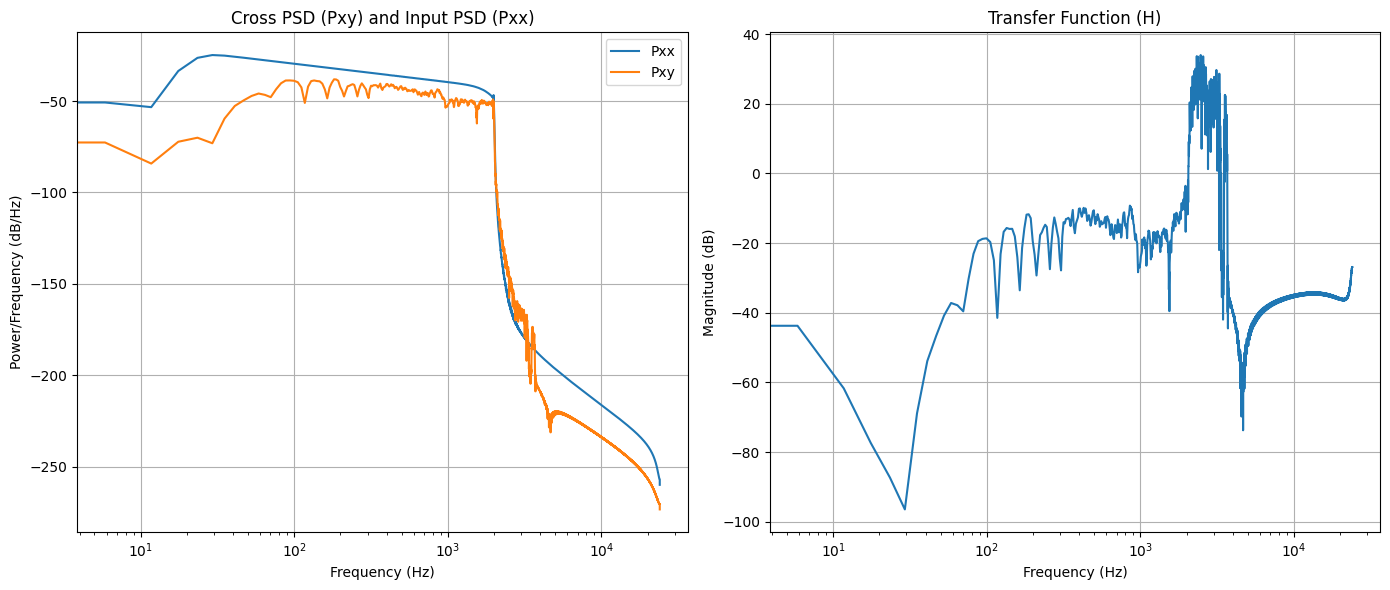

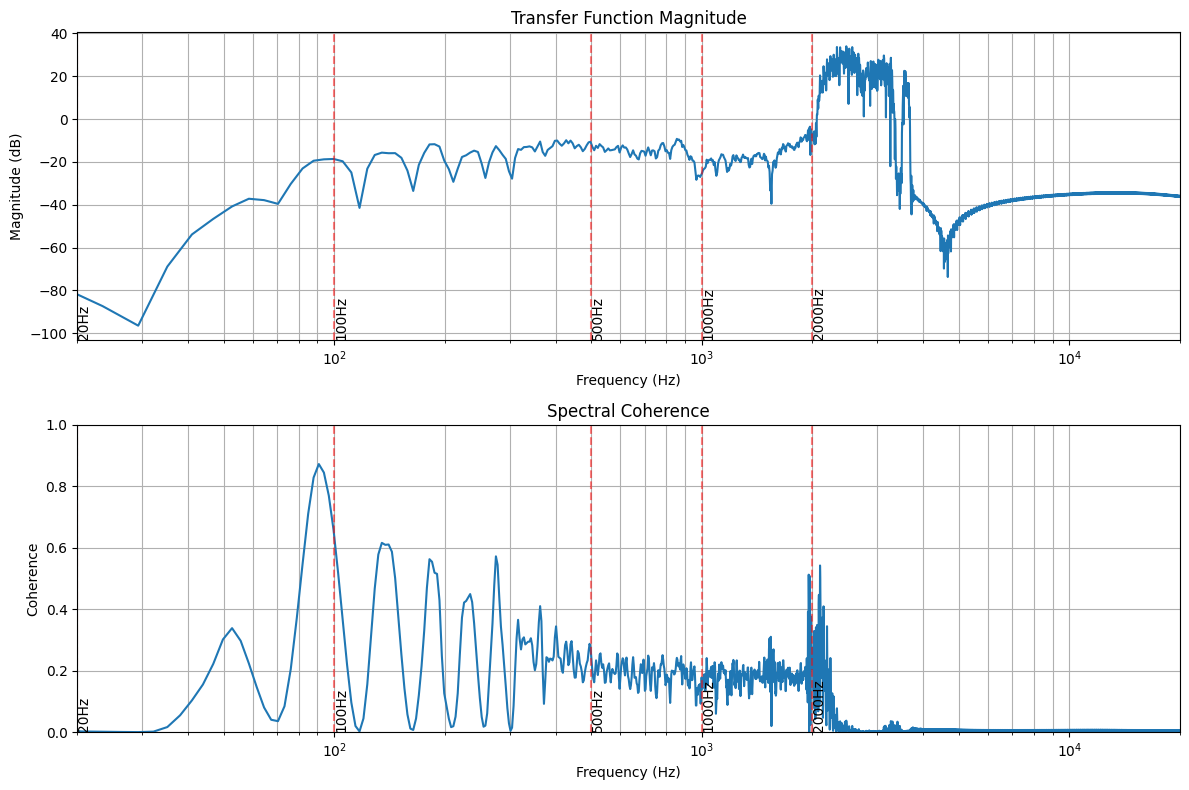

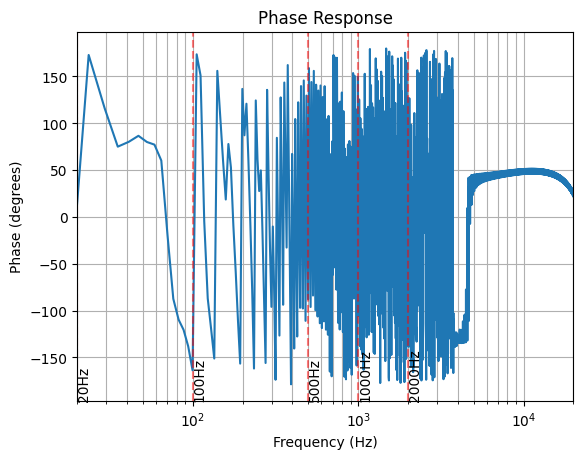

In [87]:

# Usage example:
input_file = "./audio_file/input_sweep_20_2000_20s.wav"
mba_output_file = "./audio_file/sweeping_mba_20_2000_20s.mp3"
H, freq, coherence = analyze_transfer_function(input_file, mba_output_file, plot_phase=True)

Input peak: 1.00, Output peak: 0.10
RMS ratio (output/input): -42.2 dB
Output peak after gain: 1.00
RMS ratio after gain: -22.2 dB
Motor attenuation: -34.9 dB
Speaker attenuation: 91.5 dB


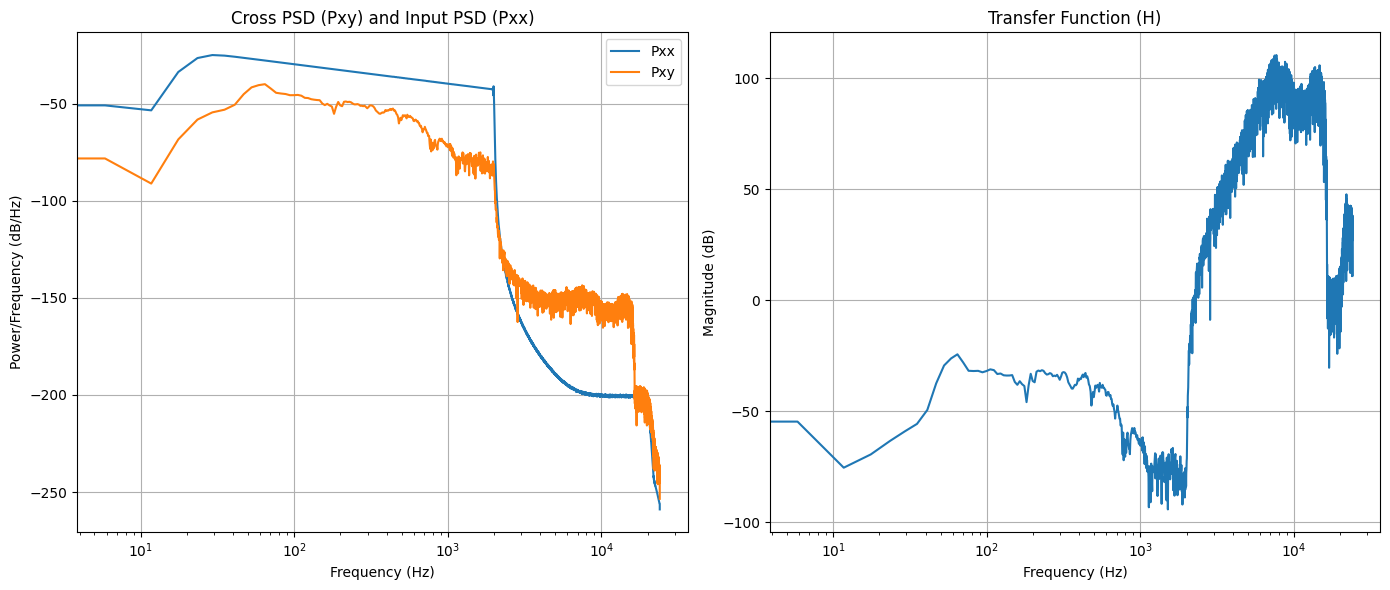

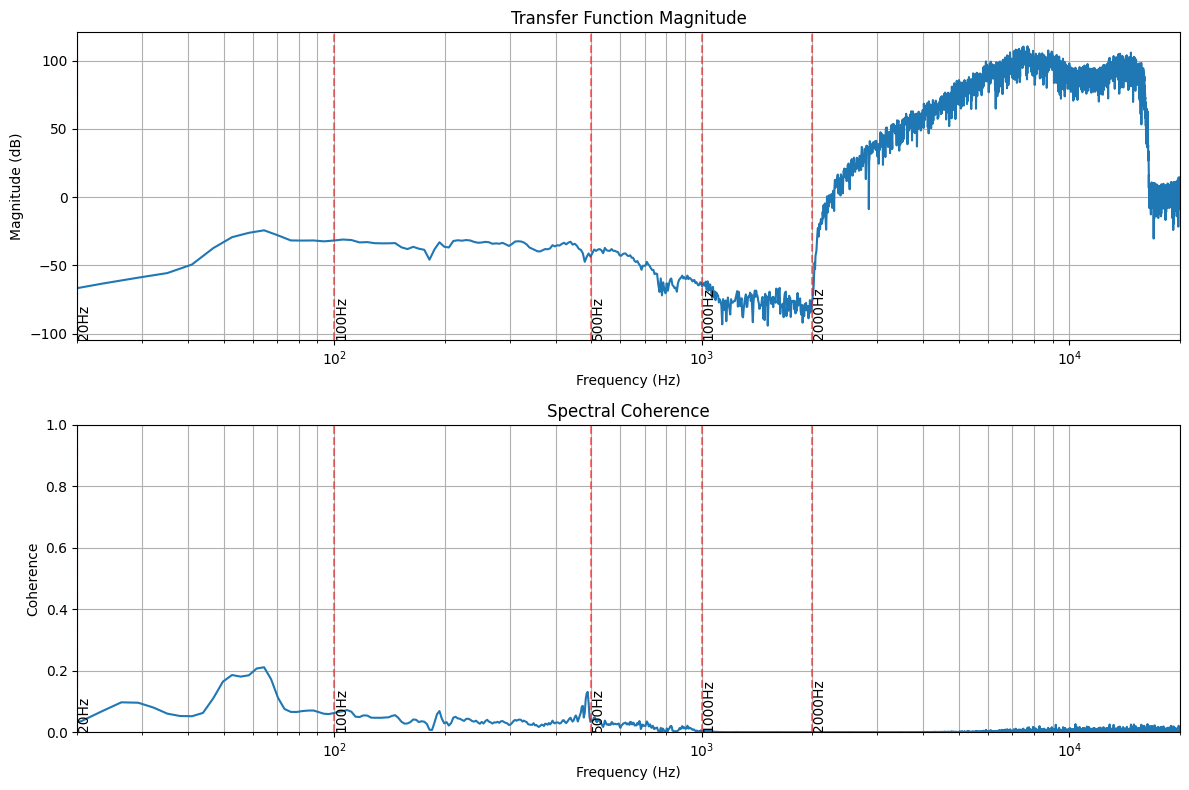

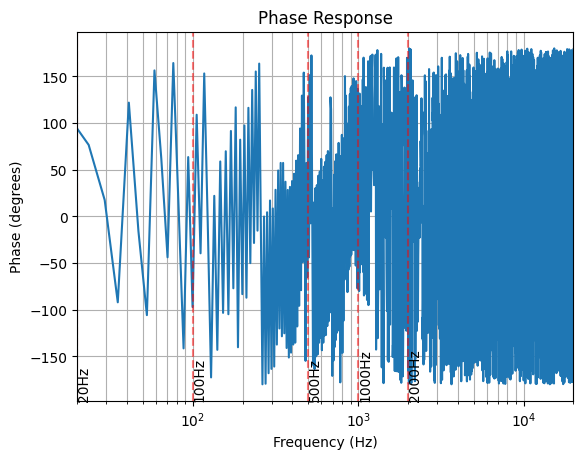

In [85]:
controller_output_file = "./audio_file/sweeping_hand_20_2000_20s.mp3"
H, freq, coherence = analyze_transfer_function(input_file, controller_output_file, plot_phase=True)


In [ ]:
# play the sweeping both on the controller and the macbook speaker 
play_sweep(20,2000,20,device_index=0,volume=1)
play_sweep(20,2000,20,device_index=3,volume=1)


In [3]:
# play tone for the certain frequency: 
freq_list=[30,300,500,1000,2000]
play_tone(30,5,device_index=0,volume=1)
play_tone(30,5,device_index=3,volume=1)
play_tone(300,5,device_index=0,volume=1)
play_tone(300,5,device_index=3,volume=1)
play_tone(500,5,device_index=0,volume=1)
play_tone(500,5,device_index=3,volume=1)
play_tone(1000,5,device_index=0,volume=1)
play_tone(1000,5,device_index=3,volume=1)
play_tone(2000,5,device_index=0,volume=1)
play_tone(2000,5,device_index=3,volume=1)

Playing 30Hz tone for 5 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0
Playing 30Hz tone for 5 seconds on device index 3
Volume level: 1, Amplitude scaling: 1.0
Playing 300Hz tone for 5 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0
Playing 300Hz tone for 5 seconds on device index 3
Volume level: 1, Amplitude scaling: 1.0
Playing 500Hz tone for 5 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0
Playing 500Hz tone for 5 seconds on device index 3
Volume level: 1, Amplitude scaling: 1.0
Playing 1000Hz tone for 5 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0
Playing 1000Hz tone for 5 seconds on device index 3
Volume level: 1, Amplitude scaling: 1.0
Playing 2000Hz tone for 5 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0
Playing 2000Hz tone for 5 seconds on device index 3
Volume level: 1, Amplitude scaling: 1.0


####  Failed: Frequency separation 
- divide the audio into two frequency range 20 500 and 500 2000 
- plot these two frequency range 

In [18]:
import numpy as np
import pyaudio
import time
import librosa
from sklearn.decomposition import NMF
from scipy.signal import butter, filtfilt
import tempfile
from pydub import AudioSegment
import os
import matplotlib.pyplot as plt


freq_list=[30,300,500,1000,2000]

def analysis_compare(audio_file_path, line_mark=False, count_source=3):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)
    
    # Plot the spectrogram
    plt.figure(figsize=(14, 6))
    S = np.abs(librosa.stft(y))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {os.path.basename(audio_file_path)}')
    
    # Add lines for each frequency in freq_list
    if line_mark:
        for freq in freq_list:
            plt.axhline(y=freq, color='red', linestyle='--', linewidth=1)
    
    plt.show()

def fft_plot(audio_file_path, line_mark=False, low_fre=0, high_fre=2500):
    y, sr = librosa.load(audio_file_path, sr=None)
    # Compute the FFT
    fft_data = np.fft.fft(y)
    fft_magnitude = np.abs(fft_data)[:len(fft_data) // 2]
    freqs = np.fft.fftfreq(len(fft_data), 1 / sr)[:len(fft_data) // 2]
    
    # Plot the FFT
    plt.figure(figsize=(14, 6))
    plt.plot(freqs, fft_magnitude, color='blue')
    plt.title(f'FFT - {os.path.basename(audio_file_path)}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(low_fre, high_fre)
    
    # Add lines for each frequency in freq_list
    if line_mark:
        for freq in freq_list:
            plt.axvline(x=freq, color='red', linestyle='--', linewidth=1)
    
    plt.show()


def normalize_audio(y):
    """Normalize audio and remove any NaN or infinite values"""
    # Replace NaN values with zeros
    y = np.nan_to_num(y, nan=0.0)
    # Clip infinite values
    y = np.clip(y, -1.0, 1.0)
    return y

def bandpass_filter(data, lowcut, highcut, fs, order=2):
    """Apply bandpass filter using librosa"""
    
    # if the range is too close, reduce the order
    if highcut - lowcut < 500:
        order = 2
        
    # Apply bandpass filter using librosa effects
    y = librosa.effects.preemphasis(data)
    # Create intervals array for remix - use full length
    intervals = np.array([[0, len(data)]])
    y = librosa.effects.remix(y, intervals)
    y = librosa.effects.time_stretch(y, rate=1.0)
    
    # Apply frequency masking within the specified range
    D = librosa.stft(y)
    n_fft = 2048  # Fixed n_fft size
    freqs = librosa.fft_frequencies(sr=fs, n_fft=n_fft)
    mask = (freqs >= lowcut) & (freqs <= highcut)
    mask_expanded = np.broadcast_to(mask[:, np.newaxis], (mask.shape[0], D.shape[1]))
    D[~mask_expanded] = 0
    y = librosa.istft(D)
    
    return normalize_audio(y)

def freq_separate(audio_file_path, range1=[20, 500], range2=[500, 2000]):
    """Separate and analyze frequency ranges in audio file"""
    try:
        # Handle M4A files
        if audio_file_path.lower().endswith('.m4a'):
            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_wav:
                audio = AudioSegment.from_file(audio_file_path, format="m4a")
                audio.export(temp_wav.name, format="wav")
                y, sr = librosa.load(temp_wav.name, sr=None)
                os.unlink(temp_wav.name)
        else:
            y, sr = librosa.load(audio_file_path, sr=None)

        # Normalize and clean audio data
        y = normalize_audio(y)

        # Validate frequency ranges
        if not all(f > 0 for f in range1 + range2):
            raise ValueError("Frequency ranges must be positive")
        
        # Apply filters
        filtered_range1 = bandpass_filter(y, range1[0], range1[1], sr)
        filtered_range2 = bandpass_filter(y, range2[0], range2[1], sr)

        # Plot spectrograms
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        D1 = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_range1)), ref=np.max)
        librosa.display.specshow(D1, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram - Range1 ({range1[0]}-{range1[1]} Hz)')

        plt.subplot(2, 1, 2)
        D2 = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_range2)), ref=np.max)
        librosa.display.specshow(D2, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram - Range2 ({range2[0]}-{range2[1]} Hz)')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing audio: {str(e)}")
        raise

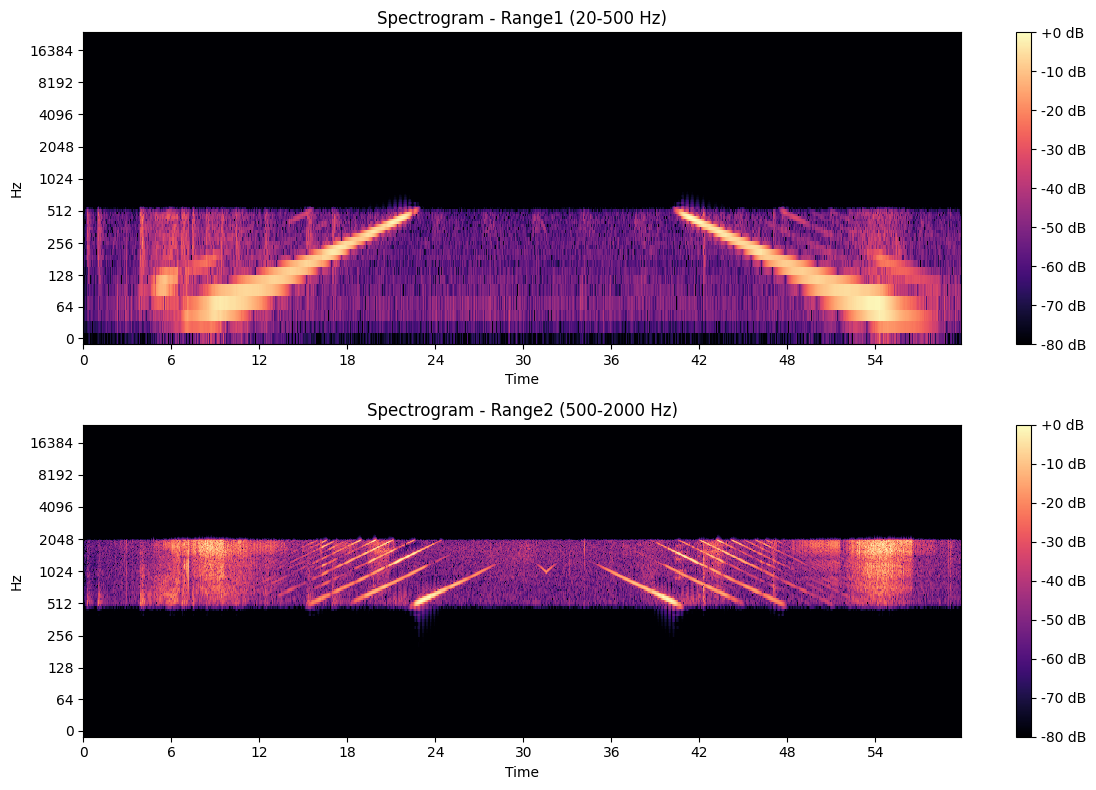

In [8]:
freq_separate("./audio_file/sweeping_hand_20_2000.m4a")

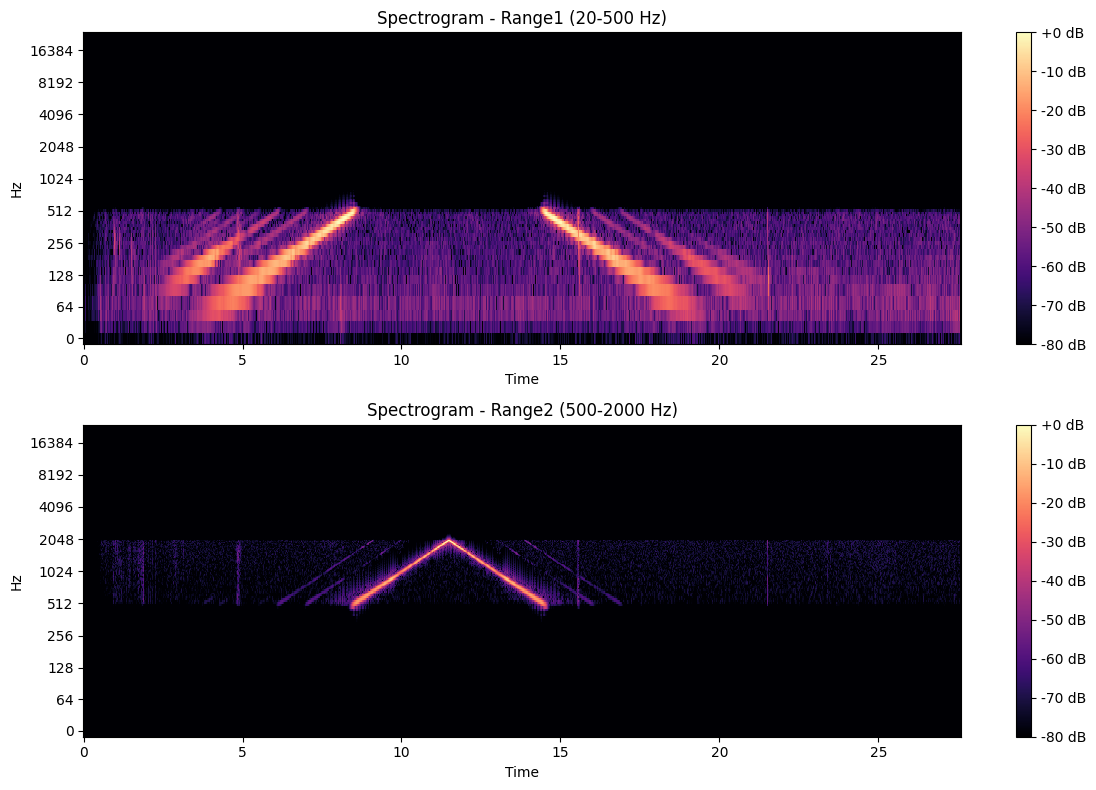

In [19]:
freq_separate("./audio_file/sweeping_mba_20_2000.m4a")

#### Failed: Cross-Correlation in Time Domain

Compute the cross-correlation between the time-domain signals filtered in different frequency ranges. If they come from different sources, they should have low cross-correlation.

####  (Failed) Spectral Subtraction 
First, we apply bandpass filters to isolate two different frequency ranges.
We then compute the spectrograms of the filtered signals.
By subtracting one spectrogram from the other, we obtain a residual spectrogram. If there are significant energy levels in the residual spectrogram, it suggests that there might be other frequency components not accounted for by the two isolated ranges, possibly indicating the presence of more than one source.

In [13]:
import numpy as np
import librosa
from scipy.signal import butter, filtfilt

sweeping_file_path="./audio_file/sweeping_hand_20_2000.m4a"

def spectral_subtraction(audio_file_path, range1=[20, 300], range2=[300, 2000]):
    # apply bandpass filter to the audio file 
    y, sr = librosa.load(audio_file_path, sr=None)
    filtered_range1 = bandpass_filter(y, range1[0], range1[1], sr)
    filtered_range2 = bandpass_filter(y, range2[0], range2[1], sr)
    
    # compute the spectrogram of the filtered signals
    S1 = np.abs(librosa.stft(filtered_range1))
    S2 = np.abs(librosa.stft(filtered_range2))
    
    # subtract the spectrogram of the two filtered signals
    residual = S2 - S1
    
    # Plot spectrograms
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 1, 1)
    D1 = librosa.amplitude_to_db(S1, ref=np.max)
    librosa.display.specshow(D1, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - Range1 ({range1[0]}-{range1[1]} Hz)')
    
    plt.subplot(3, 1, 2)
    D2 = librosa.amplitude_to_db(S2, ref=np.max)
    librosa.display.specshow(D2, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - Range2 ({range2[0]}-{range2[1]} Hz)')
    
    plt.subplot(3, 1, 3)
    D_residual = librosa.amplitude_to_db(np.abs(residual), ref=np.max)
    librosa.display.specshow(D_residual, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Residual Spectrogram')
    
    plt.tight_layout()
    plt.show()
    
    return residual


/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_38990/852449489.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path, sr=None)


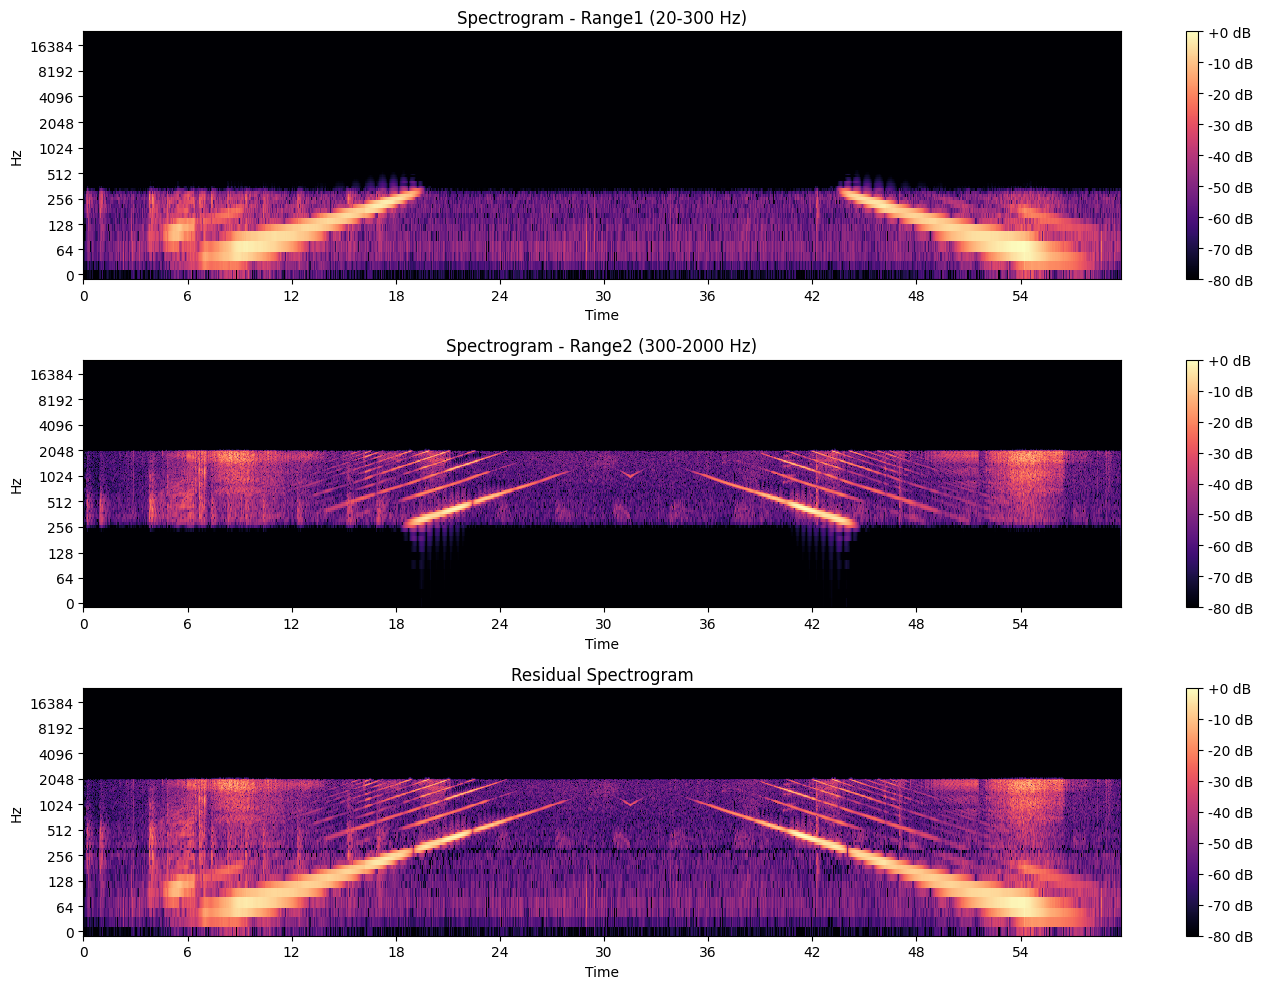

array([[-6.9328729e-05, -1.3965627e-04, -8.2179016e-05, ...,
        -5.2941585e-04, -3.8034417e-04, -1.2373185e-03],
       [-9.9304605e-05, -3.4871578e-04, -6.0343428e-04, ...,
        -8.7527120e-03, -7.2608492e-03, -3.6387783e-03],
       [-1.6904205e-04, -7.8282028e-04, -1.2798024e-03, ...,
        -2.2461727e-02, -1.7182078e-02, -6.9607105e-03],
       ...,
       [ 6.7825816e-08,  3.3863259e-08, -8.9258123e-12, ...,
         1.0124103e-11,  5.7100624e-06,  1.1401433e-05],
       [ 6.7823031e-08,  3.3863767e-08, -1.4030873e-12, ...,
         5.2209237e-11,  5.7098327e-06,  1.1401346e-05],
       [ 6.7822398e-08,  3.3860083e-08, -4.5474076e-12, ...,
         4.8754081e-11,  5.7097304e-06,  1.1401251e-05]], dtype=float32)

In [14]:
spectral_subtraction(sweeping_file_path)

/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_41669/2855145204.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path, sr=None)
/opt/miniconda3/envs/dualsense/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


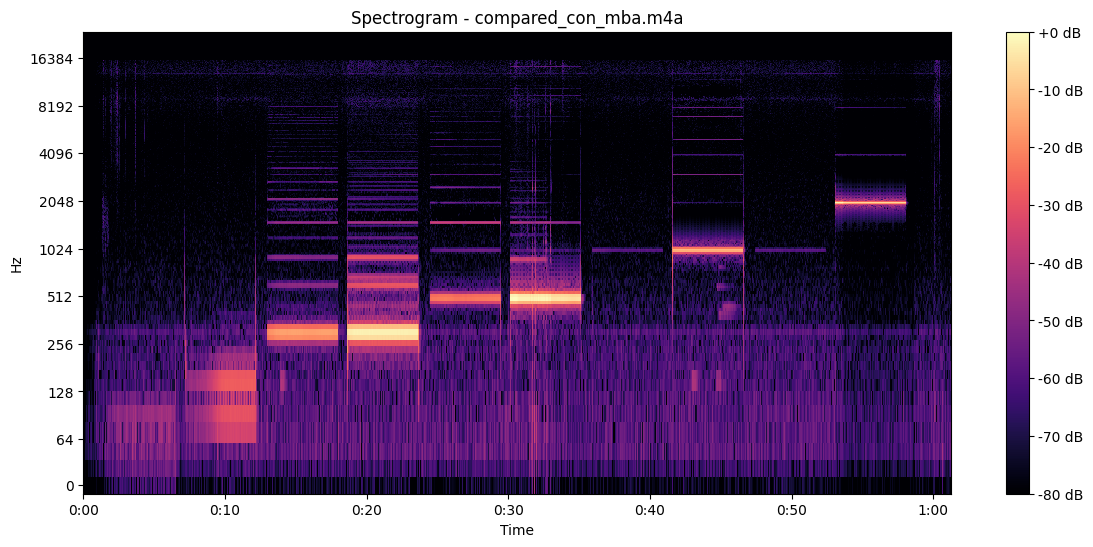

In [ ]:
analysis_compare("./audio_file/compared_con_mba.m4a")


/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_41669/158314386.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path, sr=None)


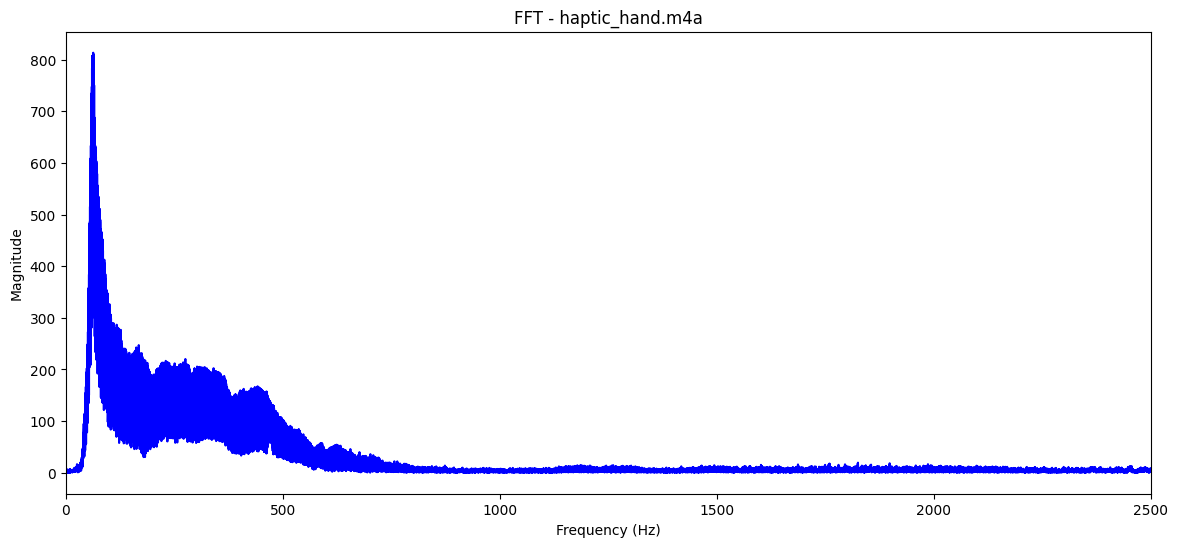

In [ ]:
fft_plot("haptic_hand.m4a")

In [5]:
play_tone(2000,12,device_index=0,volume=1)

Playing 2000Hz tone for 12 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0


In [296]:
play_tone(200,5,device_index=0,volume=1)
play_tone(200,5,device_index=3,volume=1)

Playing 200Hz tone for 5 seconds on device index 0
Volume level: 1, Amplitude scaling: 1.0
Playing 200Hz tone for 5 seconds on device index 3
Volume level: 1, Amplitude scaling: 1.0


In [ ]:
# play the sweeping sound through the mac from channel 0 and then from the chennel1
play_sweep_one_channel(20,20000,10,device_index=3,channel_index=0,total_channels=2,volume=1)
play_sweep_one_channel(20,20000,10,device_index=3,channel_index=1,total_channels=2,volume=1)

{'index': 3, 'structVersion': 2, 'name': 'MacBook Air Speakers', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.024125, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.044125, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 20Hz to 20000Hz and back for 10 seconds on channel 0
{'index': 3, 'structVersion': 2, 'name': 'MacBook Air Speakers', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.024125, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.044125, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 20Hz to 20000Hz and back for 10 seconds on channel 1


In [ ]:
# play the sweeping sound through c2 and c3 from the controller

play_sweep_one_channel(20,20000,10,device_index=0,channel_index=2,total_channels=4,volume=1)
play_sweep_one_channel(20,20000,10,device_index=0,channel_index=3,total_channels=4,volume=1)

In [202]:
# play the sweeping sound through c0 and c1 from the controller through the injax

play_sweep_one_channel(20,20000,10,device_index=0,channel_index=0,total_channels=4,volume=1)
play_sweep_one_channel(20,20000,10,device_index=0,channel_index=1,total_channels=4,volume=1)

{'index': 0, 'structVersion': 2, 'name': 'DualSense Wireless Controller', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 4, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.023854166666666666, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 20Hz to 20000Hz and back for 10 seconds on channel 0
{'index': 0, 'structVersion': 2, 'name': 'DualSense Wireless Controller', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 4, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.023854166666666666, 'defaultSampleRate': 48000.0}
Playing frequency sweep from 20Hz to 20000Hz and back for 10 seconds on channel 1


## 3 Play and listen on controller 



play the sound by certain frequency and capture all from and to controller

In [118]:
import numpy as np
import pyaudio
import time
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

def play_and_capture_sound(mic_index=0, speaker_index=None, sound_frequency=440.0, duration=5.0):
    """
    Play a tone at a certain frequency and capture the sound from a microphone.

    Args:
        mic_index (int): Index of the microphone input device.
        speaker_index (int): Index of the speaker output device.
        sound_frequency (float): Frequency of the tone to be played in Hz.
        duration (float): Duration of the tone and recording in seconds.
    """
    # Audio parameters
    sample_rate = 44100
    chunk_size = 1024
    volume = 1.0
    amplitude = 1.0
    channels = 1
    
    # Initialize PyAudio
    pa = pyaudio.PyAudio()

    try:
        # Generate the sine wave tone
        samples = np.arange(int(duration * sample_rate))
        sine_wave = np.sin(2.0 * np.pi * sound_frequency * samples / sample_rate)
        amplified_wave = sine_wave * volume * amplitude
        amplified_wave = np.clip(amplified_wave, -1.0, 1.0)
        audio_data = (amplified_wave.astype(np.float32)).tobytes()

        # Open speaker stream
        speaker_stream = pa.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=sample_rate,
            output=True,
            output_device_index=speaker_index,
            frames_per_buffer=chunk_size
        )

        # Open microphone stream
        mic_stream = pa.open(
            format=pyaudio.paInt16,
            channels=channels,
            rate=sample_rate,
            input=True,
            input_device_index=mic_index,
            frames_per_buffer=chunk_size
        )

        print(f"Playing {sound_frequency} Hz tone and recording simultaneously...")

        # Play and record simultaneously
        frames = []
        for _ in range(0, int(sample_rate / chunk_size * duration)):
            speaker_stream.write(audio_data[:chunk_size * 4])
            mic_data = mic_stream.read(chunk_size)
            frames.append(np.frombuffer(mic_data, dtype=np.int16))

        # Close streams
        speaker_stream.stop_stream()
        speaker_stream.close()
        mic_stream.stop_stream()
        mic_stream.close()

        # Combine frames into a single numpy array
        audio_data = np.concatenate(frames)

        # Reshape for multi-channel (if applicable)
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            audio_data = audio_data[:, 0]  # Analyze the first channel

        # Time domain visualization
        plt.figure(figsize=(14, 6))
        plt.subplot(2, 1, 1)
        time_axis = np.linspace(0, len(audio_data) / sample_rate, num=len(audio_data))
        plt.plot(time_axis, audio_data, color='blue')
        plt.title("Sound Wave")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Frequency domain visualization
        fft_data = fft(audio_data)
        fft_magnitude = np.abs(fft_data)[:len(fft_data) // 2]
        freqs = fftfreq(len(audio_data), 1 / sample_rate)[:len(fft_data) // 2]

        # Find two largest peaks in the FFT magnitude
        sorted_indices = np.argsort(fft_magnitude)[::-1]  # Sort indices of peaks in descending order
        peak1_idx = sorted_indices[0]  # Largest peak
        peak2_idx = sorted_indices[1]  # Second largest peak

        peak1_freq = freqs[peak1_idx]
        peak2_freq = freqs[peak2_idx]
        peak1_mag = fft_magnitude[peak1_idx]
        peak2_mag = fft_magnitude[peak2_idx]

        # Plot FFT with the two dominant peaks highlighted
        plt.subplot(2, 1, 2)
        plt.plot(freqs, fft_magnitude, color='green')
        plt.title("Dominant Frequencies")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.text(peak1_freq, peak1_mag, f'{peak1_freq:.2f} Hz', color='red')
        plt.text(peak2_freq, peak2_mag, f'{peak2_freq:.2f} Hz', color='blue')

        plt.tight_layout()
        plt.show()

        print(f"Dominant Frequencies: {peak1_freq:.2f} Hz and {peak2_freq:.2f} Hz")

    finally:
        pa.terminate()


Playing 120 Hz tone and recording simultaneously...


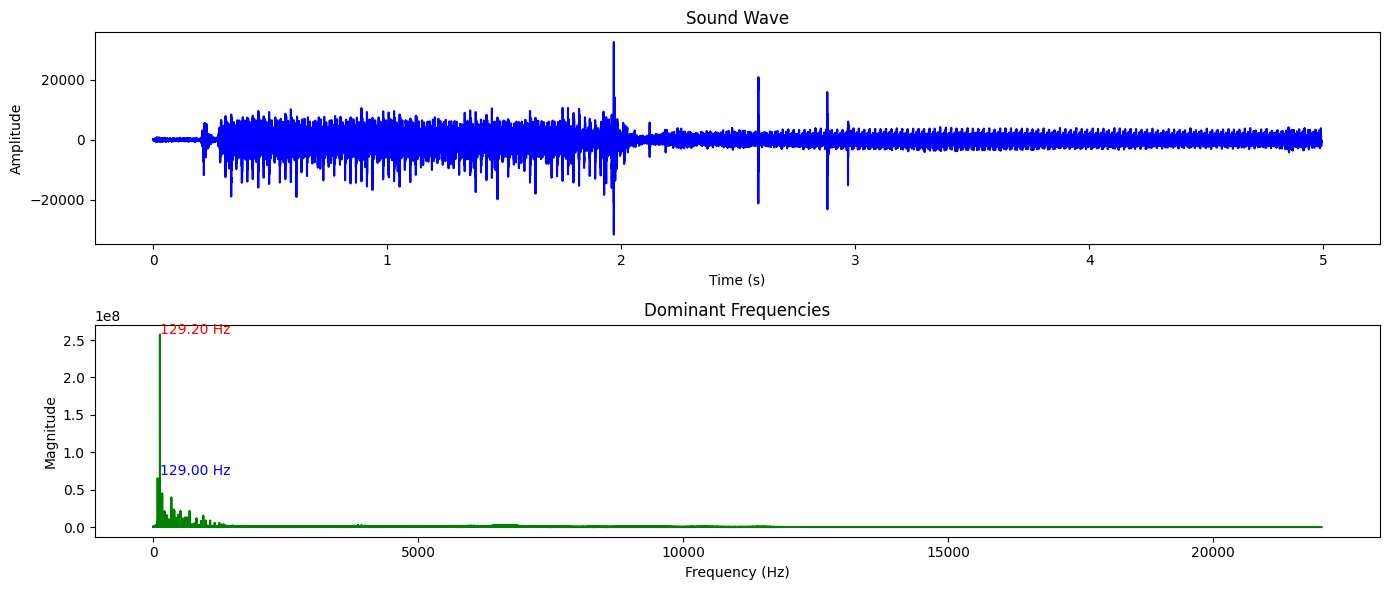

Dominant Frequencies: 129.20 Hz and 129.00 Hz


In [134]:

speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=120, duration=5.0)



Playing 900 Hz tone and recording simultaneously...


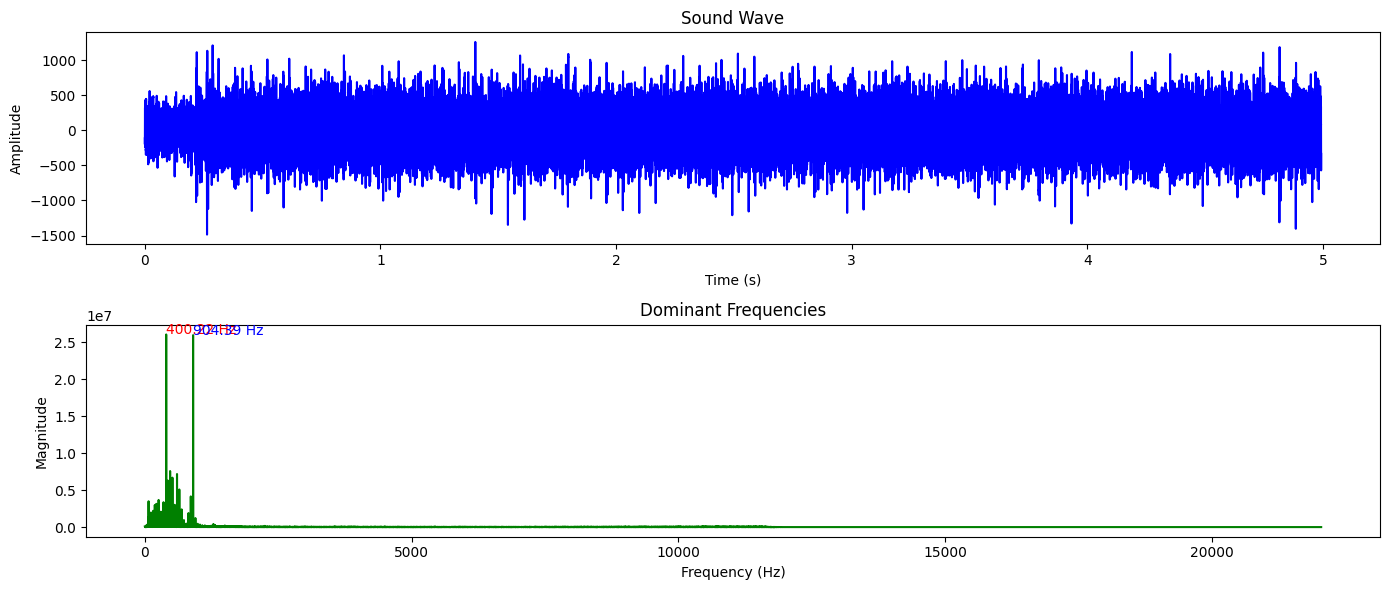

Dominant Frequencies: 400.22 Hz and 904.39 Hz


In [140]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=900, duration=5.0)

Playing 800 Hz tone and recording simultaneously...


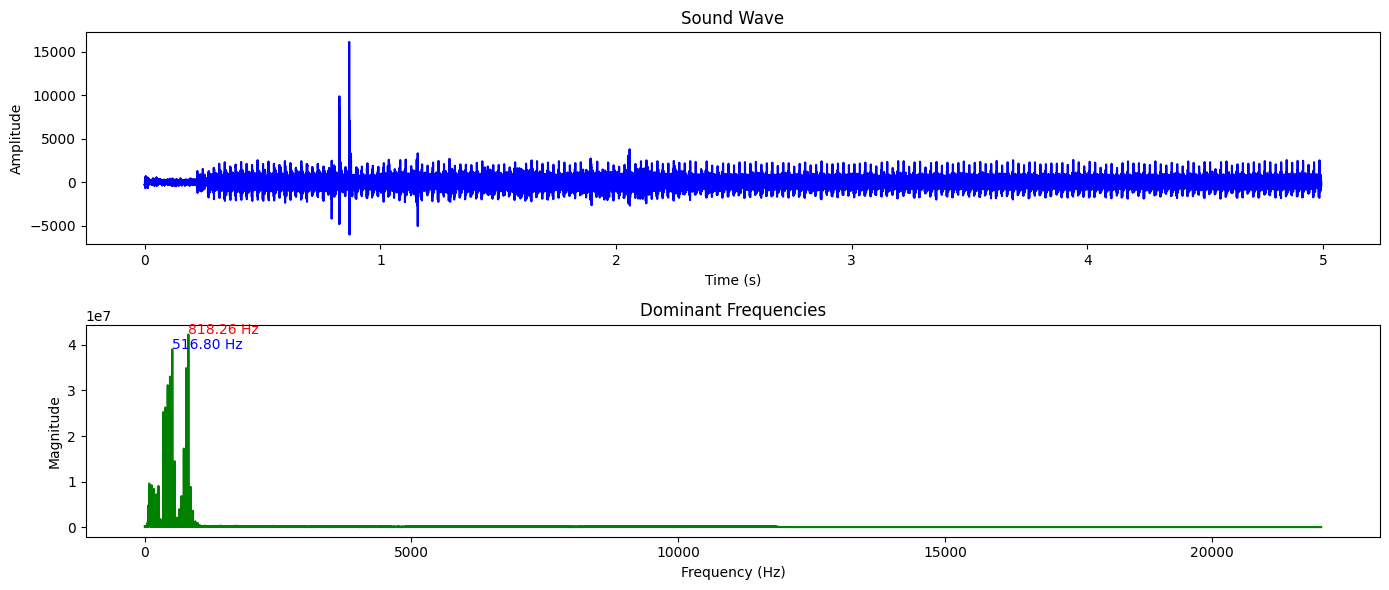

Dominant Frequencies: 818.26 Hz and 516.80 Hz


In [124]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=800, duration=5.0)

Playing 700 Hz tone and recording simultaneously...


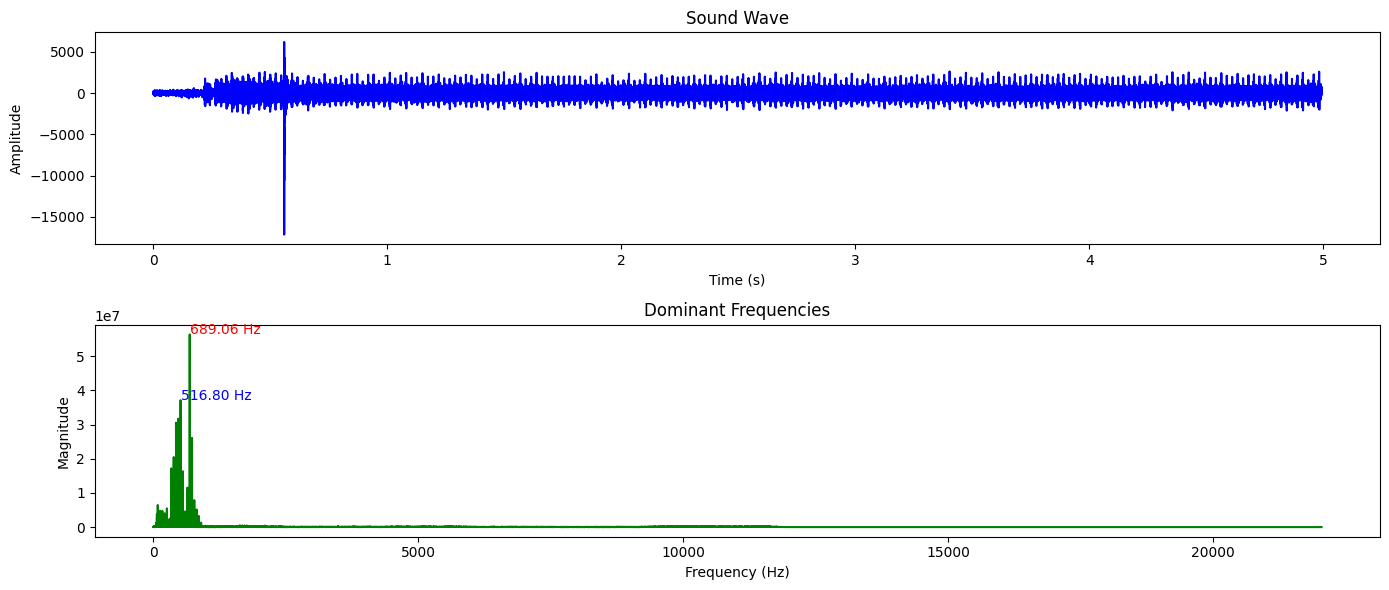

Dominant Frequencies: 689.06 Hz and 516.80 Hz


In [125]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=700, duration=5.0)

Playing 600 Hz tone and recording simultaneously...


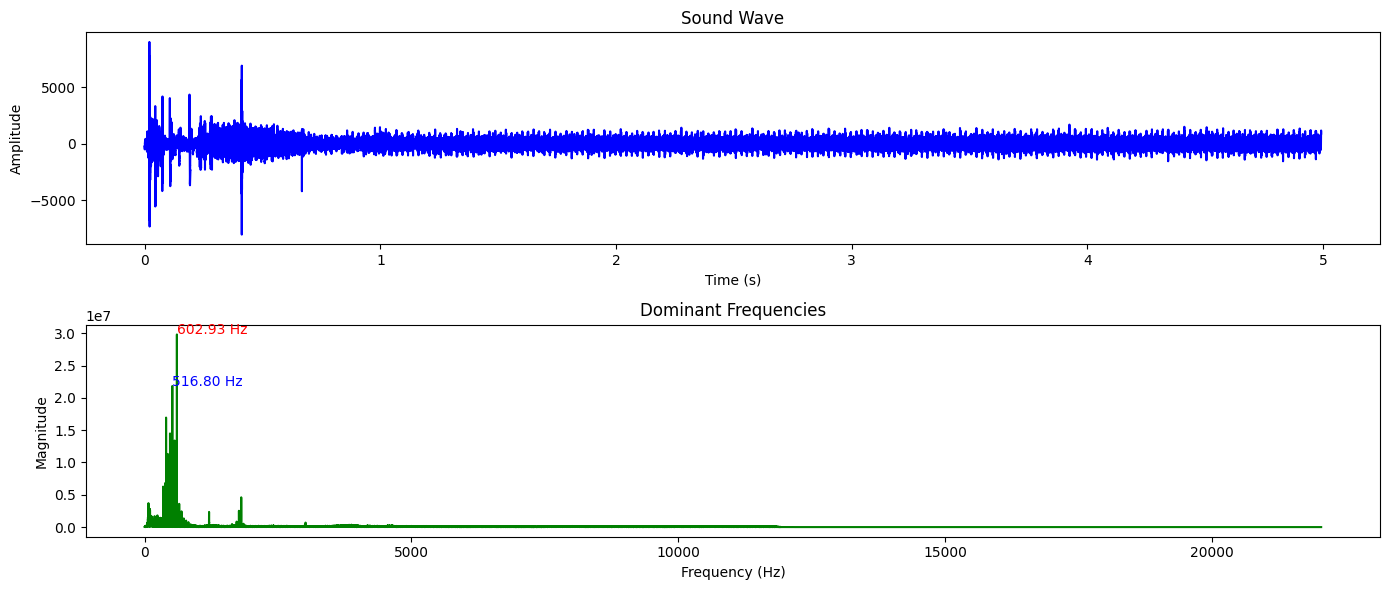

Dominant Frequencies: 602.93 Hz and 516.80 Hz


In [126]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=600, duration=5.0)

Playing 400 Hz tone and recording simultaneously...


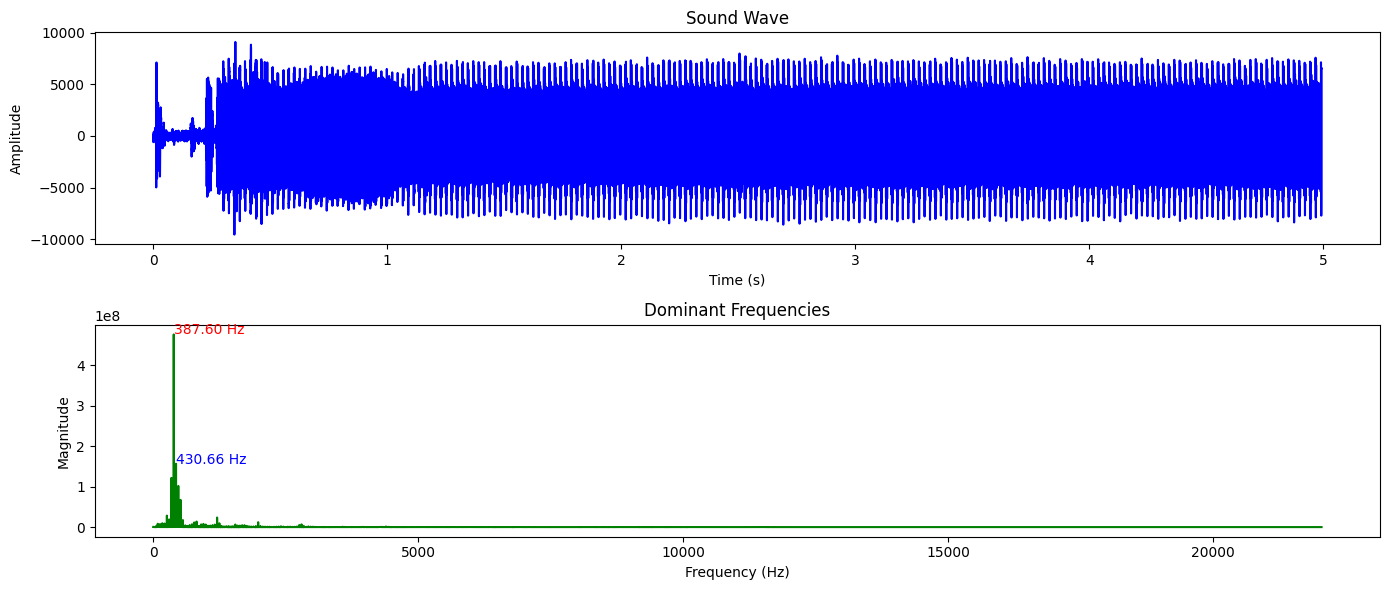

Dominant Frequencies: 387.60 Hz and 430.66 Hz


In [127]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=400, duration=5.0)

Playing 300 Hz tone and recording simultaneously...


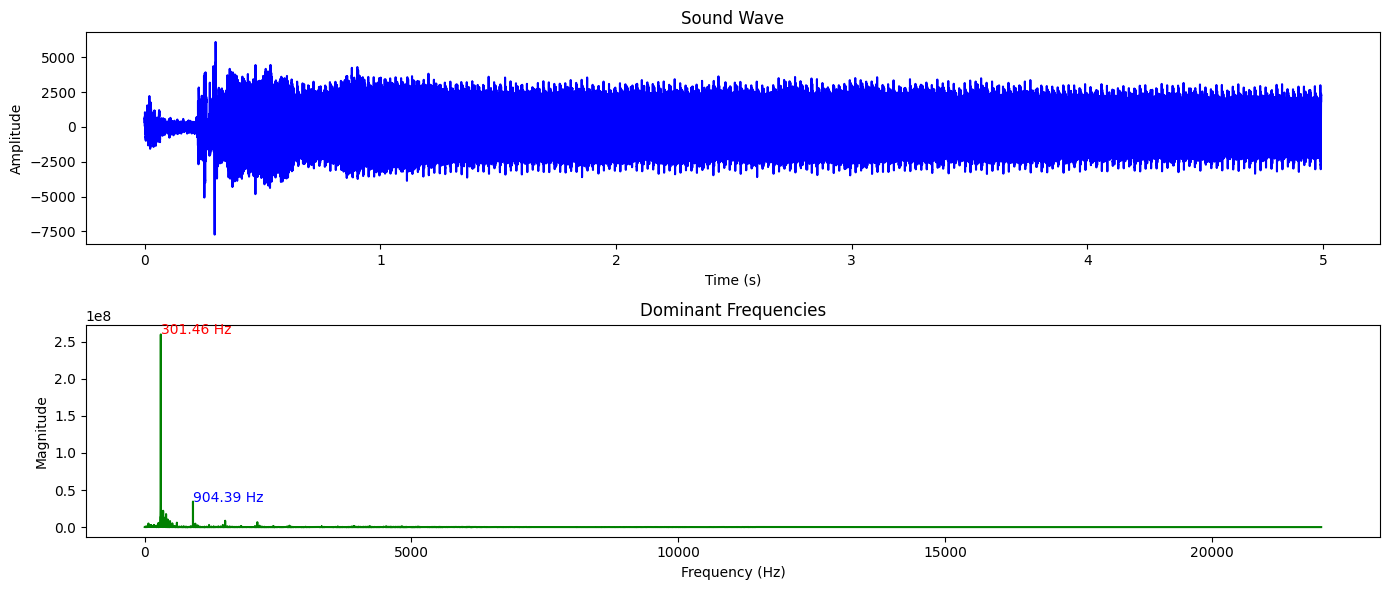

Dominant Frequencies: 301.46 Hz and 904.39 Hz


In [128]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=300, duration=5.0)

Playing 80 Hz tone and recording simultaneously...


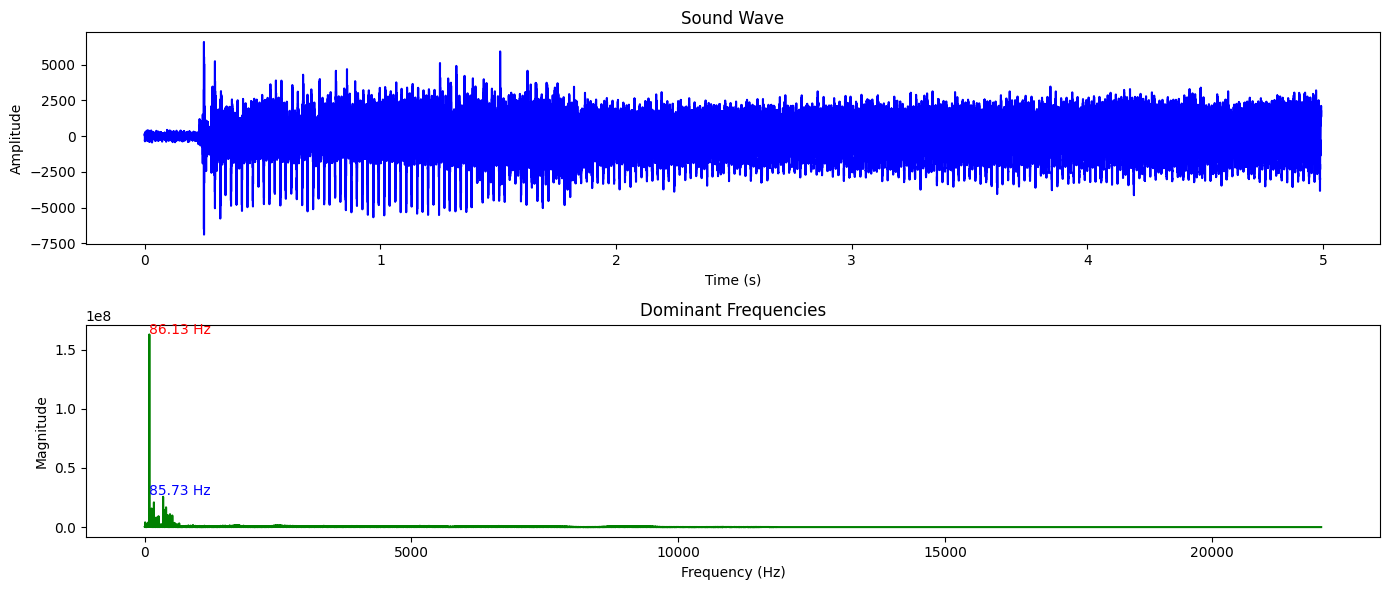

Dominant Frequencies: 86.13 Hz and 85.73 Hz


In [129]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=80, duration=5.0)

Playing 120 Hz tone and recording simultaneously...


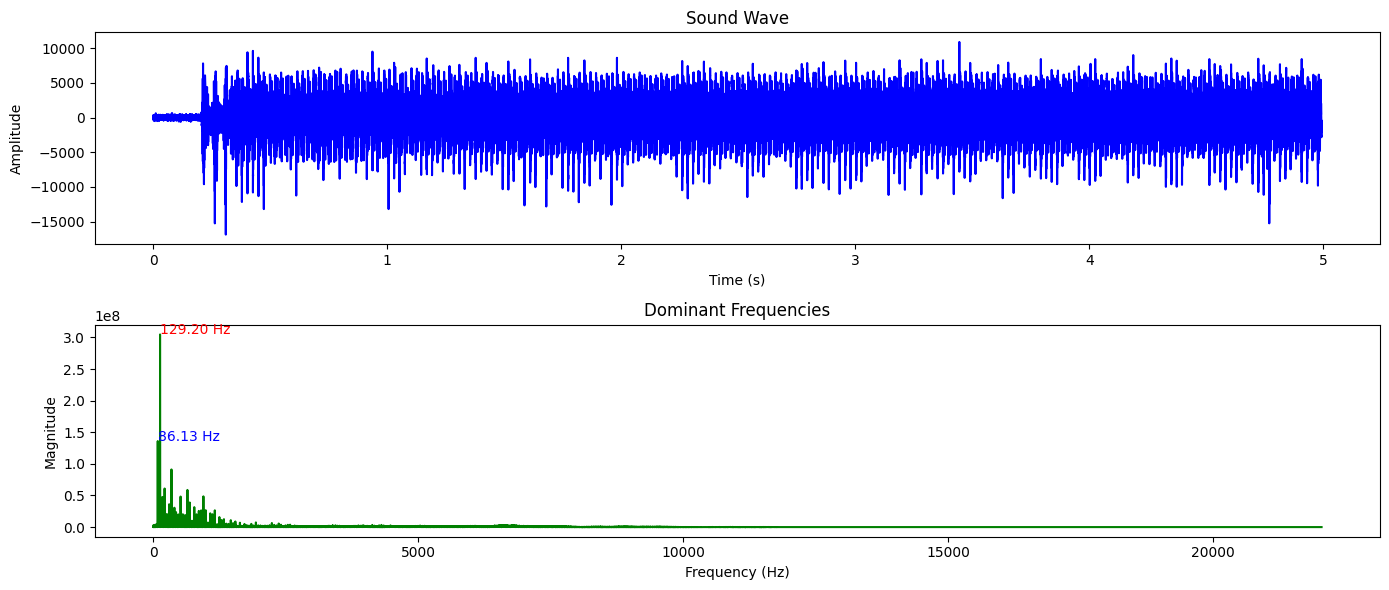

Dominant Frequencies: 129.20 Hz and 86.13 Hz


In [139]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=120, duration=5.0)

## 4 Conclusion


Conclusion:

- Harmonics and Aliasing Interactions: When playing a tone at frequencies like 900Hz or 800Hz, two prominent peaks are detected in the frequency spectrum—one around 400Hz or 450Hz, and the other at the played frequency. This phenomenon is due to harmonics and aliasing interactions.

- Low Frequency Detection: Frequencies below 120Hz are not detectable by the system. The Linear Resonant Actuator (LRA) exhibits more noticeable vibration at these lower frequencies compared to higher frequencies.

- Effective Sound Frequency Range: The effective sound frequency range for the internal microphone is between 120Hz and 900Hz. Within this range, some frequencies may show additional harmonic or aliasing effects.

- Frequency range of the controlelr's mic 100hz to 11800hz 